# Adaptive and Gradient Boosting

In this notebook, we demonstrate the use of AdaBoost and gradient boosting, incuding several state-of-the-art implementations of this very powerful and flexible algorithm that greatly speed up training. 

We use the stock return dataset with a few engineered factors created in [Chapter 4 on Alpha Factor Research](../04_alpha_factor_research) in the notebook [feature_engineering](../04_alpha_factor_research/00_data/feature_engineering.ipynb).

## Update

This notebook now uses `sklearn.ensemble.HistGradientBoostingClassifier`.

## Imports and Settings

In [53]:
%matplotlib inline

import sys, os
import warnings
from time import time
from itertools import product
import joblib
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
# needed for HistGradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.inspection import partial_dependence, plot_partial_dependence
from sklearn.metrics import roc_auc_score

In [3]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
#from utils import format_time

In [4]:
results_path = Path('results', 'baseline')
if not results_path.exists():
    results_path.mkdir(exist_ok=True, parents=True)

In [5]:
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
idx = pd.IndexSlice
np.random.seed(42)

## Prepare Data

### Get source

We use the `engineered_features` dataset created in [Chapter 4, Alpha Factor Research](../04_alpha_factor_research)

Set data store location:

In [66]:
DATA_STORE = '../Machine-Learning-for-Algorithmic-Trading-Second-Edition-master/Machine-Learning-for-Algorithmic-Trading-Second-Edition-master/data/assets.h5'

In [107]:
def get_data():
    
    data = pd.read_csv('./data/pcafeatureset.csv')
    #data.date = pd.to_datetime(data.date)
    data.set_index(['ticker','date'], inplace=True)
    data.dropna(inplace=True)
    idx = pd.IndexSlice
    
    symbol = 'GOOGL'
    X = data.iloc[:,:30]
    y = pd.DataFrame((data.iloc[:,-6]>0).astype(int))
    
    return y, X

### Factorize Categories

Define columns with categorical data:

### One-Hot Encoding

Create dummy variables from categorical columns if needed:

### Get Holdout Set

Create holdout test set to estimate generalization error after cross-validation:

In [ ]:
def factorize_cats(df, cats=['sector']):
    cat_cols = ['year', 'month', 'age', 'msize'] + cats
    for cat in cats:
        df[cat] = pd.factorize(df[cat])[0]
    df.loc[:, cat_cols] = df.loc[:, cat_cols].fillna(-1).astype(int)
    return df

In [70]:
def get_one_hot_data(df, cols=cat_cols[:-1]):
    df = pd.get_dummies(df,
                        columns=cols + ['sector'],
                        prefix=cols + [''],
                        prefix_sep=['_'] * len(cols) + [''])
    return df.rename(columns={c: c.replace('.0', '') for c in df.columns})

NameError: name 'cat_cols' is not defined

In [33]:
def get_holdout_set(target, features, period=6):
    idx = pd.IndexSlice
    label = target.name
    dates = np.sort(y.index.get_level_values('date').unique())
    cv_start, cv_end = dates[0], dates[-period - 2]
    holdout_start, holdout_end = dates[-period - 1], dates[-1]

    df = features.join(target.to_frame())
    train = df.loc[idx[:, cv_start: cv_end], :]
    y_train, X_train = train[label], train.drop(label, axis=1)

    test = df.loc[idx[:, holdout_start: holdout_end], :]
    y_test, X_test = test[label], test.drop(label, axis=1)
    return y_train, X_train, y_test, X_test

## Load Data

The algorithms in this chapter use a dataset generated in [Chapter 4 on Alpha Factor Research](../04_alpha_factor_research) in the notebook [feature-engineering](../04_alpha_factor_research/00_data/feature_engineering.ipynb) that needs to be executed first.

In [108]:
y, X_dummies = get_data()

In [109]:
X_dummies.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 709062 entries, ('A', '2015-01-02') to ('ZTS', '2020-10-01')
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       709062 non-null  float64
 1   1       709062 non-null  float64
 2   2       709062 non-null  float64
 3   3       709062 non-null  float64
 4   4       709062 non-null  float64
 5   5       709062 non-null  float64
 6   6       709062 non-null  float64
 7   7       709062 non-null  float64
 8   8       709062 non-null  float64
 9   9       709062 non-null  float64
 10  10      709062 non-null  float64
 11  11      709062 non-null  float64
 12  12      709062 non-null  float64
 13  13      709062 non-null  float64
 14  14      709062 non-null  float64
 15  15      709062 non-null  float64
 16  16      709062 non-null  float64
 17  17      709062 non-null  float64
 18  18      709062 non-null  float64
 19  19      709062 non-null  float64
 20  20      709062 

In [13]:
# y_clean, features_clean = get_data(dropna=True)
# X_dummies_clean = get_one_hot_data(features_clean)
# X_factors_clean = factorize_cats(features_clean)

## Cross-Validation Setup

### Custom Time Series KFold Generator

Custom Time Series KFold generator.

In [110]:
class OneStepTimeSeriesSplit:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the index contains a level labeled 'date'"""

    def __init__(self, n_splits=3, test_period_length=1, shuffle=False):
        self.n_splits = n_splits
        self.test_period_length = test_period_length
        self.shuffle = shuffle

    @staticmethod
    def chunks(l, n):
        for i in range(0, len(l), n):
            yield l[i:i + n]

    def split(self, X, y=None, groups=None):
        unique_dates = (X.index
                        .get_level_values('date')
                        .unique()
                        .sort_values(ascending=False)
                        [:self.n_splits*self.test_period_length])

        dates = X.reset_index()[['date']]
        for test_date in self.chunks(unique_dates, self.test_period_length):
            train_idx = dates[dates.date < min(test_date)].index
            test_idx = dates[dates.date.isin(test_date)].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [111]:
cv = OneStepTimeSeriesSplit(n_splits=12, 
                            test_period_length=1, 
                            shuffle=False)

In [112]:
run_time = {}

### CV Metrics

Define some metrics for use with cross-validation:

In [113]:
metrics = {'balanced_accuracy': 'Accuracy' ,
           'roc_auc': 'AUC',
           'neg_log_loss': 'Log Loss',
           'f1_weighted': 'F1',
           'precision_weighted': 'Precision',
           'recall_weighted': 'Recall'
}

Helper function that runs cross-validation for the various algorithms.

In [114]:
def run_cv(clf, X=X_dummies, y=y, metrics=metrics, cv=cv, fit_params=None, n_jobs=-1):
    start = time()
    scores = cross_validate(estimator=clf,
                            X=X, 
                            y=y,
                            scoring=list(metrics.keys()),
                            cv=cv,
                            return_train_score=True,
                            n_jobs=n_jobs,
                            verbose=1,
                            fit_params=fit_params)
    print(scores)
    duration = time() - start
    return scores, duration

### CV Result Handler Functions

The following helper functions manipulate and plot the cross-validation results to produce the outputs below.

In [115]:
def stack_results(scores):
    columns = pd.MultiIndex.from_tuples(
        [tuple(m.split('_', 1)) for m in scores.keys()],
        names=['Dataset', 'Metric'])
    data = np.array(list(scores.values())).T
    df = (pd.DataFrame(data=data,
                       columns=columns)
          .iloc[:, 2:])
    results = pd.melt(df, value_name='Value')
    results.Metric = results.Metric.apply(lambda x: metrics.get(x))
    results.Dataset = results.Dataset.str.capitalize()
    return results

In [116]:
def plot_result(df, model=None, fname=None):
    m = list(metrics.values())
    g = sns.catplot(x='Dataset', 
                    y='Value', 
                    hue='Dataset', 
                    col='Metric',
                    data=df, 
                    col_order=m,
                    order=['Train', 'Test'],
                    kind="box", 
                    col_wrap=3,
                    sharey=False,
                    height=4, aspect=1.2)
    df = df.groupby(['Metric', 'Dataset']).Value.mean().unstack().loc[m]
    for i, ax in enumerate(g.axes.flat):
        s = f"Train: {df.loc[m[i], 'Train']:>7.4f}\nTest:  {df.loc[m[i], 'Test'] :>7.4f}"
        ax.text(0.05, 0.85, s, fontsize=10, transform=ax.transAxes, 
                bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round,pad=0.5'))
    g.fig.suptitle(model, fontsize=16)
    g.fig.subplots_adjust(top=.9)
    if fname:
        g.savefig(fname, dpi=300);

## Baseline Classifier

`sklearn` provides the [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) that makes predictions using simple rule and is useful as a simple baseline to compare with the other (real) classifiers we use below.

The `stratified` rule generates predictions based on the training set’s class distribution, i.e. always predicts the most frequent class.

In [117]:
dummy_clf = DummyClassifier(strategy='stratified',
                            random_state=42)

In [118]:
algo = 'dummy_clf'

In [119]:
X_dummies.index.dtype

dtype('O')

In [120]:
fname = results_path / f'i{algo}.joblib'
if not Path(fname).exists():
    dummy_cv_result, run_time[algo] = run_cv(dummy_clf)
    joblib.dump(dummy_cv_result, fname)
else:
    dummy_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   10.1s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   10.2s finished


{'fit_time': array([0.70924282, 0.69312787, 0.74048352, 0.70924616, 0.68807983,
       0.67212296, 0.67428946, 0.68990707, 0.53604436, 0.52754879,
       0.52754879, 0.51193595]), 'score_time': array([0.0312407 , 0.01611495, 0.01562119, 0.01561189, 0.01561189,
       0.03123307, 0.01562119, 0.01562119, 0.0209446 , 0.01562786,
       0.01562786, 0.01561666]), 'test_balanced_accuracy': array([0.48385942, 0.52489242, 0.4751254 , 0.50734962, 0.44341398,
       0.52982456, 0.50776137, 0.44617689, 0.47786201, 0.48105991,
       0.49143755, 0.49427549]), 'train_balanced_accuracy': array([0.50093591, 0.49990155, 0.50089846, 0.49973369, 0.50140274,
       0.49994279, 0.5004599 , 0.49936654, 0.4995234 , 0.50010539,
       0.49937525, 0.49993432]), 'test_roc_auc': array([0.48385942, 0.52489242, 0.4751254 , 0.50734962, 0.44341398,
       0.52982456, 0.50776137, 0.44617689, 0.47786201, 0.48105991,
       0.49143755, 0.49427549]), 'train_roc_auc': array([0.50093591, 0.49990155, 0.50089846, 0.4997336

Unsurprisingly, it produces results near the AUC threshold for arbitrary predictions of 0.5:

In [121]:
dummy_result = stack_results(dummy_cv_result)
dummy_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.488587,0.500132
Accuracy,0.488587,0.500132
F1,0.542459,0.501495
Log Loss,-17.402794,-17.218170
Precision,0.653679,0.501501
Recall,0.496144,0.501489


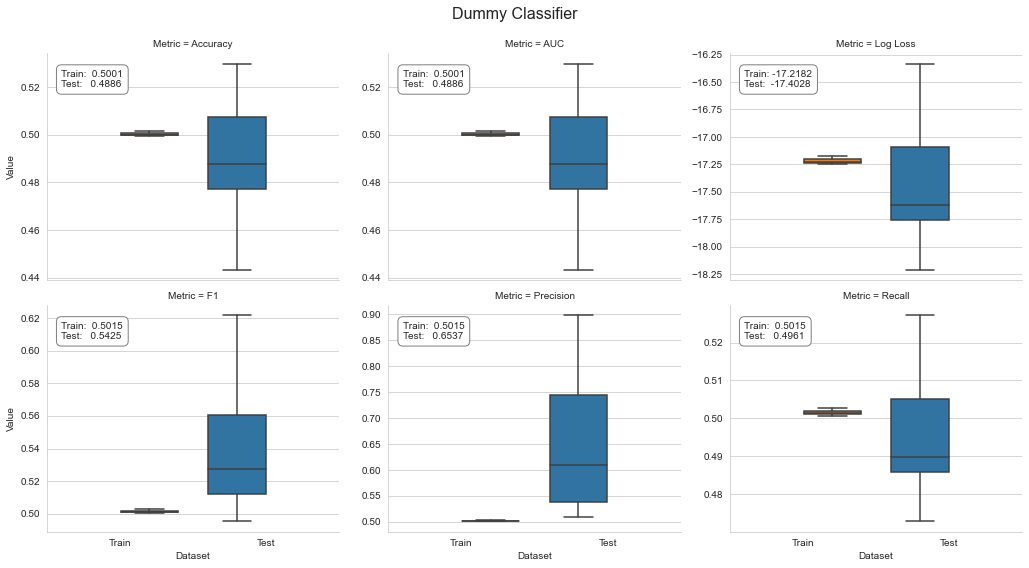

In [122]:
plot_result(dummy_result, model='Dummy Classifier')

## RandomForest

For comparison, we train a `RandomForestClassifier` as presented in [Chapter 11 on Decision Trees and Random Forests](../11_decision_trees_random_forests/02_random_forest.ipynb).

### Configure

In [123]:
rf_clf = RandomForestClassifier(n_estimators=100,
                                criterion='gini', 
                                max_depth=None, 
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto',
                                max_leaf_nodes=None, 
                                min_impurity_decrease=0.0, 
                                min_impurity_split=None, 
                                bootstrap=True, 
                                oob_score=True, 
                                n_jobs=-1,
                                random_state=42, 
                                verbose=1)

### Cross-validate

In [124]:
algo = 'random_forest'

In [126]:
fname = results_path / f'i{algo}.joblib'
if not Path(fname).exists():
    rf_cv_result, run_time[algo] = run_cv(rf_clf, y=y, X=X_dummies)
    joblib.dump(rf_cv_result, fname)
else:
    rf_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed: 65.2min remaining: 13.0min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 65.4min finished


{'fit_time': array([2436.83612323, 2443.13401914, 2450.61369395, 2417.49811673,
       2391.93582487, 2449.48688579, 2436.00541282, 2446.68244743,
       1317.29770064, 1248.17068791, 1185.6589992 , 1181.20110583]), 'score_time': array([6.17292643, 7.03756189, 8.31197357, 1.32965755, 0.73538804,
       8.31044245, 6.72392917, 6.1429584 , 0.17183185, 1.86590958,
       1.04997993, 1.27250552]), 'test_balanced_accuracy': array([0.51437653, 0.49651605, 0.48476823, 0.56667078, 0.44862231,
       0.55543478, 0.47543212, 0.47555497, 0.55895224, 0.55287314,
       0.48242996, 0.42703041]), 'train_balanced_accuracy': array([1.        , 1.        , 0.99999866, 0.99999866, 0.99999851,
       0.99999851, 1.        , 1.        , 0.99999865, 1.        ,
       0.99999865, 0.9999985 ]), 'test_roc_auc': array([0.50647668, 0.52543032, 0.47915766, 0.58888409, 0.35961022,
       0.53394355, 0.43819433, 0.42926357, 0.55693804, 0.58475613,
       0.48211574, 0.42993739]), 'train_roc_auc': array([1., 1., 1

### Plot Results

In [127]:
rf_result = stack_results(rf_cv_result)
rf_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.492892,1.000000
Accuracy,0.503222,0.999999
F1,0.413541,0.999999
Log Loss,-0.752993,-0.170010
Precision,0.659046,0.999999
Recall,0.405265,0.999999


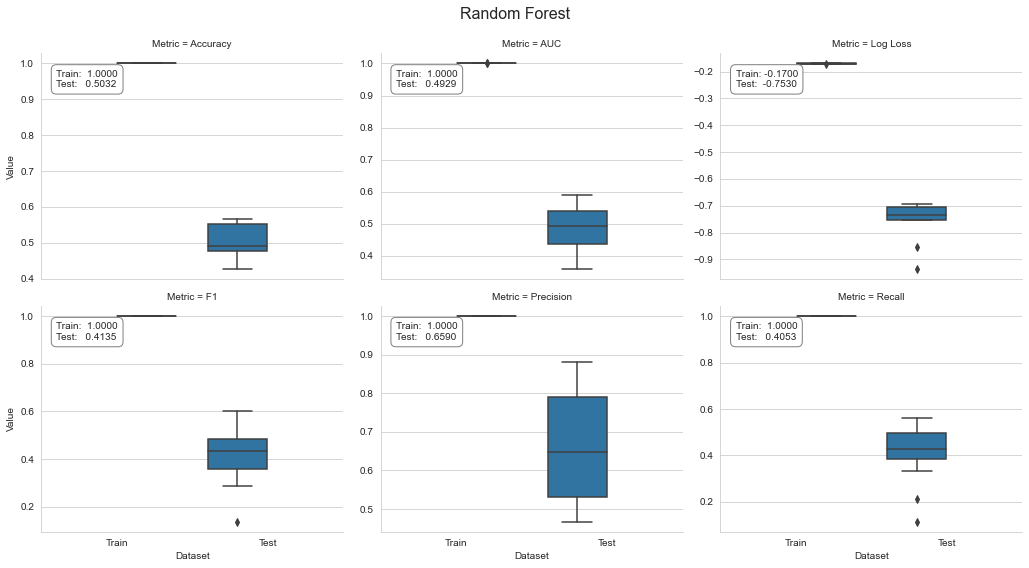

In [128]:
plot_result(rf_result, model='Random Forest')

## scikit-learn: AdaBoost

As part of its [ensemble module](https://scikit-learn.org/stable/modules/ensemble.html#adaboost), sklearn provides an [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) implementation that supports two or more classes. The code examples for this section are in the notebook gbm_baseline that compares the performance of various algorithms with a dummy classifier that always predicts the most frequent class.

### Base Estimator

We need to first define a base_estimator as a template for all ensemble members and then configure the ensemble itself. We'll use the default DecisionTreeClassifier with max_depth=1—that is, a stump with a single split. The complexity of the base_estimator is a key tuning parameter because it depends on the nature of the data. 

As demonstrated in the [previous chapter](../../10_decision_trees_random_forests), changes to `max_depth` should be combined with appropriate regularization constraints using adjustments to, for example, `min_samples_split`:

In [129]:
base_estimator = DecisionTreeClassifier(criterion='gini', 
                                        splitter='best',
                                        max_depth=1, 
                                        min_samples_split=2, 
                                        min_samples_leaf=20, 
                                        min_weight_fraction_leaf=0.0,
                                        max_features=None, 
                                        random_state=None, 
                                        max_leaf_nodes=None, 
                                        min_impurity_decrease=0.0, 
                                        min_impurity_split=None, 
                                        class_weight=None)

### AdaBoost Configuration

In the second step, we'll design the ensemble. The n_estimators parameter controls the number of weak learners and the learning_rate determines the contribution of each weak learner, as shown in the following code. By default, weak learners are decision tree stumps:

In [130]:
ada_clf = AdaBoostClassifier(base_estimator=base_estimator,
                             n_estimators=100,
                             learning_rate=1.0,
                             algorithm='SAMME.R',
                             random_state=42)

The main tuning parameters that are responsible for good results are `n_estimators` and the base estimator complexity because the depth of the tree controls the extent of the interaction among the features. 

### Cross-validate

We will cross-validate the AdaBoost ensemble using a custom 12-fold rolling time-series split to predict 1 month ahead for the last 12 months in the sample, using all available prior data for training, as shown in the following code:

In [131]:
algo = 'adaboost'

In [132]:
fname = results_path / f'i{algo}.joblib'
if not Path(fname).exists():
    ada_cv_result, run_time[algo] = run_cv(ada_clf, y=y, X=X_dummies)
    joblib.dump(ada_cv_result, fname)
else:
    ada_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed: 42.5min remaining:  8.5min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 42.8min finished


{'fit_time': array([1217.59135747, 1209.86240864, 1200.07548833, 1190.82720518,
       1200.02773523, 1213.56044865, 1218.09235644, 1193.41223431,
        971.60275269,  964.70495987,  988.69471073,  976.37077713]), 'score_time': array([0.2843225 , 0.2966187 , 0.26793742, 0.25148106, 0.27015209,
       0.24993777, 0.26728296, 0.28118515, 0.20307851, 0.22103786,
       0.17183042, 0.24994183]), 'test_balanced_accuracy': array([0.48039951, 0.47168984, 0.50713483, 0.55437688, 0.53148522,
       0.50034325, 0.5518879 , 0.5121124 , 0.5433055 , 0.64215776,
       0.46338047, 0.49458855]), 'train_balanced_accuracy': array([0.53750642, 0.53768895, 0.53737024, 0.53709411, 0.53791767,
       0.53869718, 0.53792347, 0.53858131, 0.53849564, 0.53747642,
       0.53740567, 0.5377989 ]), 'test_roc_auc': array([0.48006715, 0.43512082, 0.51838839, 0.54346038, 0.49909274,
       0.50532037, 0.5780584 , 0.56448203, 0.60160771, 0.67619791,
       0.42944488, 0.50031306]), 'train_roc_auc': array([0.5618838

### Plot Result

In [133]:
ada_result = stack_results(ada_cv_result)
ada_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.527629,0.562715
Accuracy,0.521072,0.537830
F1,0.493607,0.526935
Log Loss,-0.693238,-0.692987
Precision,0.672037,0.546741
Recall,0.473675,0.549052


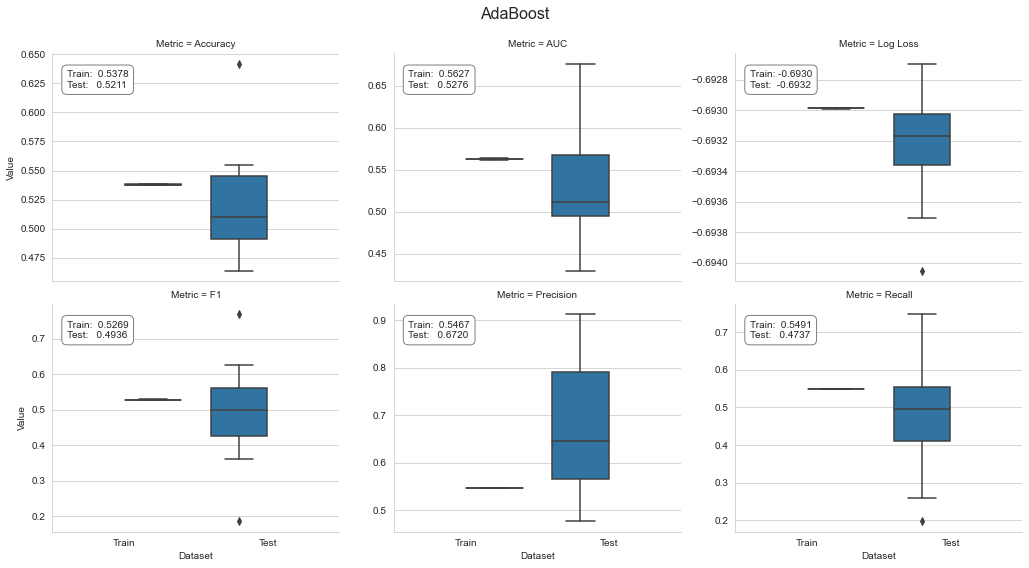

In [134]:
plot_result(ada_result, model='AdaBoost')

## scikit-learn: HistGradientBoostingClassifier

The ensemble module of sklearn contains an implementation of gradient boosting trees for regression and classification, both binary and multiclass. 

### Configure

The following [HistGradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html) initialization code illustrates the key tuning parameters that we previously introduced, in addition to those that we are familiar with from looking at standalone decision tree models.

This estimator is much faster than [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier) for big datasets (n_samples >= 10 000).

This estimator has native support for missing values (NaNs). During training, the tree grower learns at each split point whether samples with missing values should go to the left or right child, based on the potential gain. When predicting, samples with missing values are assigned to the left or right child consequently. If no missing values were encountered for a given feature during training, then samples with missing values are mapped to whichever child has the most samples.

In [37]:
gb_clf = HistGradientBoostingClassifier(loss='binary_crossentropy',              
                                        learning_rate=0.1,          # regulates the contribution of each tree
                                        max_iter=100,               # number of boosting stages
                                        min_samples_leaf=20,
                                        max_depth=None,
                                        random_state=None,
                                        max_leaf_nodes=31,           # opt value depends on feature interaction
                                        warm_start=False,
#                                         early_stopping=True,
#                                         scoring='loss',
#                                         validation_fraction=0.1,
#                                         n_iter_no_change=None,
                                        verbose=0,
                                        tol=0.0001)

### Cross-validate

In [38]:
algo = 'sklearn_gbm'

In [39]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    gb_cv_result, run_time[algo] = run_cv(gb_clf, y=y_clean, X=X_dummies_clean)
    joblib.dump(gb_cv_result, fname)
else:
    gb_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   52.5s remaining:   10.5s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   53.5s finished


### Plot Results

In [40]:
gb_result = stack_results(gb_cv_result)
gb_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.531743,0.749078
Accuracy,0.505791,0.675196
F1,0.448612,0.681376
Log Loss,-0.697194,-0.595612
Precision,0.551708,0.692833
Recall,0.543934,0.689301


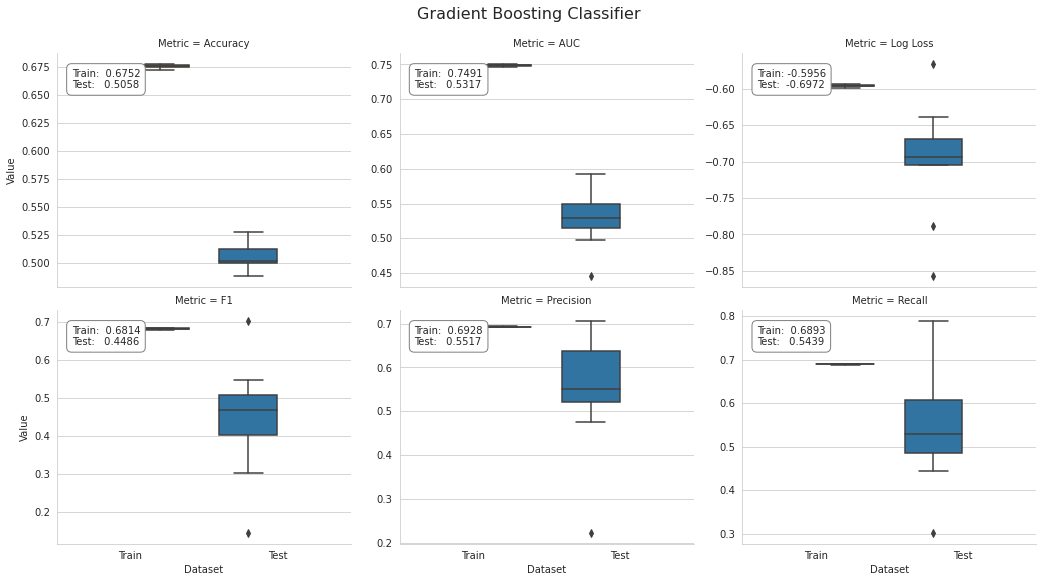

In [41]:
plot_result(gb_result, model='Gradient Boosting Classifier')

### Partial Dependence Plots

Drop time periods to avoid over-reliance for in-sample fit.

In [42]:
X_ = X_factors_clean.drop(['year', 'month'], axis=1)

In [43]:
fname = results_path / f'{algo}_model.joblib'
if not Path(fname).exists():
    gb_clf.fit(y=y_clean, X=X_)
    joblib.dump(gb_clf, fname)
else:
    gb_clf = joblib.load(fname)

In [44]:
# mean accuracy
gb_clf.score(X=X_, y=y_clean)

0.5826965098819537

In [45]:
y_score = gb_clf.predict_proba(X_)[:, 1]
roc_auc_score(y_score=y_score, y_true=y_clean)

0.6056119291581973

#### One-way and two-way partial depende plots

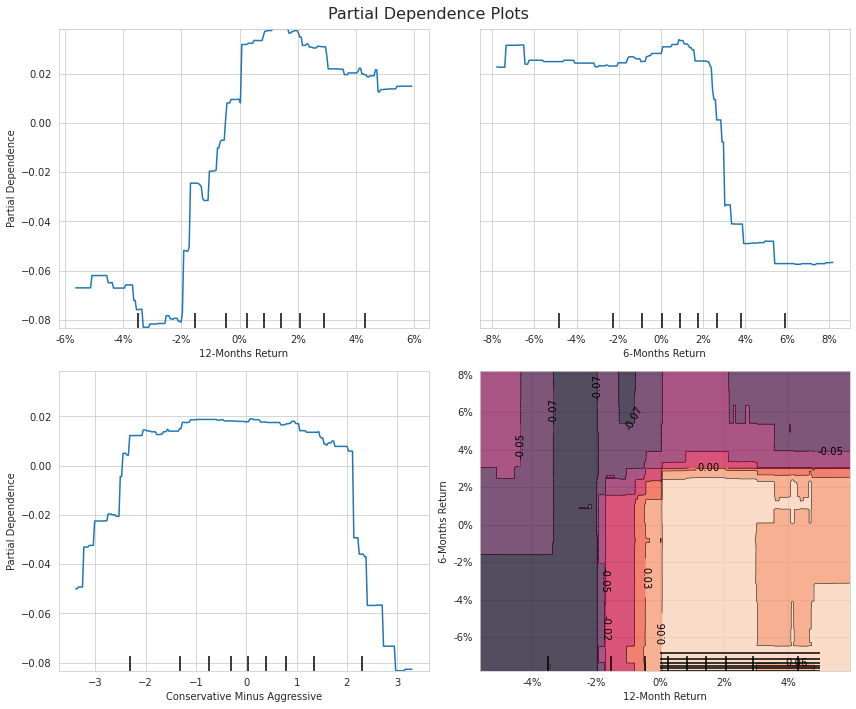

In [46]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

plot_partial_dependence(
    estimator=gb_clf,
    X=X_,
    features=['return_12m', 'return_6m', 'CMA', ('return_12m', 'return_6m')],
    percentiles=(0.05, 0.95),
    n_jobs=-1,
    n_cols=2,
    response_method='decision_function',
    grid_resolution=250,
    ax=axes)

for i, j in product([0, 1], repeat=2):
    if i!=1 or j!= 0:
        axes[i][j].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

axes[1][1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

axes[0][0].set_ylabel('Partial Dependence')
axes[1][0].set_ylabel('Partial Dependence')
axes[0][0].set_xlabel('12-Months Return')
axes[0][1].set_xlabel('6-Months Return')
axes[1][0].set_xlabel('Conservative Minus Aggressive')

axes[1][1].set_xlabel('12-Month Return')
axes[1][1].set_ylabel('6-Months Return')
fig.suptitle('Partial Dependence Plots', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=.95)


#### Two-way partial dependence as 3D plot

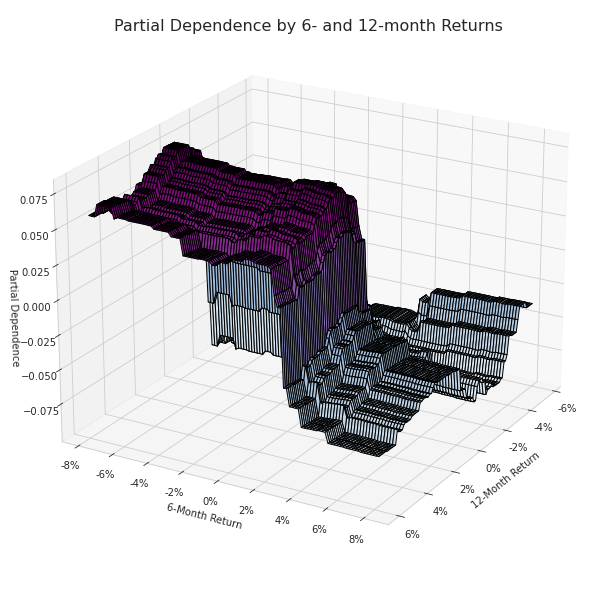

In [47]:
targets = ['return_12m', 'return_6m']
pdp, axes = partial_dependence(estimator=gb_clf,
                               features=targets,
                               X=X_,
                               grid_resolution=100)

XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].reshape(list(map(np.size, axes))).T

fig = plt.figure(figsize=(14, 8))
ax = Axes3D(fig)
surface = ax.plot_surface(XX, YY, Z,
                          rstride=1,
                          cstride=1,
                          cmap=plt.cm.BuPu,
                          edgecolor='k')
ax.set_xlabel('12-Month Return')
ax.set_ylabel('6-Month Return')
ax.set_zlabel('Partial Dependence')
ax.view_init(elev=22, azim=30)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# fig.colorbar(surface)
fig.suptitle('Partial Dependence by 6- and 12-month Returns', fontsize=16)
fig.tight_layout()


## XGBoost

See XGBoost [docs](https://xgboost.readthedocs.io/en/latest/python/python_api.html) for details on parameters and usage.

### Configure

In [135]:
xgb_clf = XGBClassifier(max_depth=3,                  # Maximum tree depth for base learners.
                        learning_rate=0.1,            # Boosting learning rate (xgb's "eta")
                        n_estimators=100,             # Number of boosted trees to fit.
                        silent=True,                  # Whether to print messages while running
                        objective='binary:logistic',  # Task and objective or custom objective function
                        booster='gbtree',             # Select booster: gbtree, gblinear or dart
#                         tree_method='gpu_hist',
                        n_jobs=-1,                    # Number of parallel threads
                        gamma=0,                      # Min loss reduction for further splits
                        min_child_weight=1,           # Min sum of sample weight(hessian) needed
                        max_delta_step=0,             # Max delta step for each tree's weight estimation
                        subsample=1,                  # Subsample ratio of training samples
                        colsample_bytree=1,           # Subsample ratio of cols for each tree
                        colsample_bylevel=1,          # Subsample ratio of cols for each split
                        reg_alpha=0,                  # L1 regularization term on weights
                        reg_lambda=1,                 # L2 regularization term on weights
                        scale_pos_weight=1,           # Balancing class weights
                        base_score=0.5,               # Initial prediction score; global bias
                        random_state=42)              # random seed

### Cross-validate

In [136]:
algo = 'xgboost'

In [137]:
fname = results_path / f'i{algo}.joblib'
if not Path(fname).exists():
    xgb_cv_result, run_time[algo] = run_cv(xgb_clf)
    joblib.dump(xgb_cv_result, fname)
else:
    xgb_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed: 25.7min remaining:  5.1min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 25.7min finished


{'fit_time': array([988.19852924, 976.89390898, 988.2610147 , 979.18597317,
       993.06457973, 998.72989106, 998.19571829, 999.89526772,
       515.83514261, 514.12360525, 512.82408023, 511.10941362]), 'score_time': array([0.89218998, 1.87435222, 1.04233789, 1.19826412, 0.8757298 ,
       1.60439897, 1.21114278, 1.04998803, 0.32897139, 0.5198729 ,
       0.32752323, 0.03124261]), 'test_balanced_accuracy': array([0.54507261, 0.49546508, 0.47601185, 0.52128819, 0.58397177,
       0.46229977, 0.52296526, 0.48581748, 0.58369955, 0.61234013,
       0.46577638, 0.45700358]), 'train_balanced_accuracy': array([0.54865375, 0.54988885, 0.54951736, 0.54933633, 0.54945357,
       0.55030395, 0.5508209 , 0.55006376, 0.55108365, 0.54958623,
       0.55048979, 0.54838762]), 'test_roc_auc': array([0.57097082, 0.47852532, 0.45792614, 0.53832079, 0.59156586,
       0.47528604, 0.53597919, 0.49127907, 0.61200835, 0.72633254,
       0.44125426, 0.45514311]), 'train_roc_auc': array([0.59272958, 0.5939229

### Plot Results

In [138]:
xbg_result = stack_results(xgb_cv_result)
xbg_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.531216,0.594204
Accuracy,0.517643,0.549799
F1,0.475299,0.523594
Log Loss,-0.706097,-0.679735
Precision,0.679752,0.574831
Recall,0.469819,0.565026


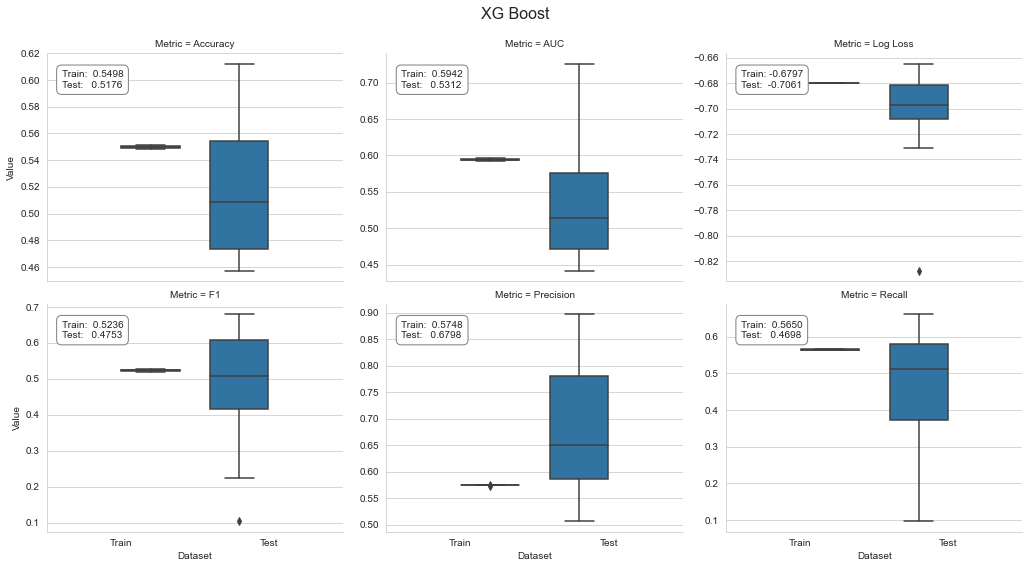

In [141]:
plot_result(xbg_result, model='XG Boost')

### Feature Importance

In [142]:
xgb_clf.fit(X=X_dummies, y=y)

[10:35:52] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:35:54] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=True,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [143]:
fi = pd.Series(xgb_clf.feature_importances_, 
               index=X_dummies.columns)

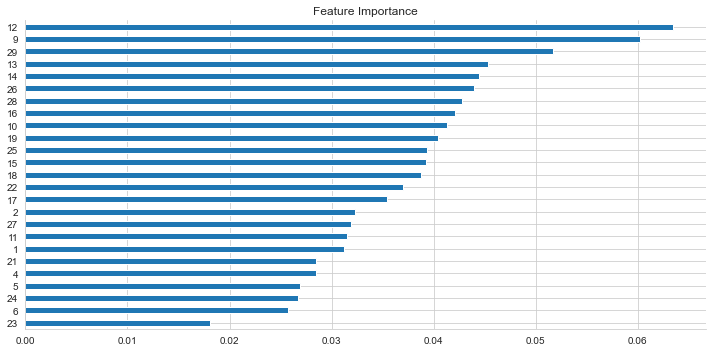

In [144]:
fi.nlargest(25).sort_values().plot.barh(figsize=(10, 5), 
                                        title='Feature Importance')
sns.despine()
plt.tight_layout();

## LightGBM

See LightGBM [docs](https://lightgbm.readthedocs.io/en/latest/Parameters.html) for details on parameters and usage.

### Configure

In [145]:
lgb_clf = LGBMClassifier(boosting_type='gbdt',
#                          device='gpu',
                         objective='binary',          # learning task
                         metric='auc',
                         num_leaves=31,               # Maximum tree leaves for base learners.
                         max_depth=-1,                # Maximum tree depth for base learners, -1 means no limit.
                         learning_rate=0.1,          # Adaptive lr via callback override in .fit() method  
                         n_estimators=100,            # Number of boosted trees to fit
                         subsample_for_bin=200000,    # Number of samples for constructing bins.
                         class_weight=None,           # dict, 'balanced' or None
                         min_split_gain=0.0,          # Minimum loss reduction for further split
                         min_child_weight=0.001,      # Minimum sum of instance weight(hessian)
                         min_child_samples=20,        # Minimum number of data need in a child(leaf)
                         subsample=1.0,               # Subsample ratio of training samples
                         subsample_freq=0,            # Frequency of subsampling, <=0: disabled
                         colsample_bytree=1.0,        # Subsampling ratio of features
                         reg_alpha=0.0,               # L1 regularization term on weights
                         reg_lambda=0.0,              # L2 regularization term on weights
                         random_state=42,             # Random number seed; default: C++ seed
                         n_jobs=-1,                   # Number of parallel threads.
                         silent=False,
                         importance_type='gain',      # default: 'split' or 'gain'
                        )

### Cross-Validate

#### Using categorical features

In [146]:
algo = 'lgb_factors'

In [148]:
fname = results_path / f'i{algo}.joblib'
if not Path(fname).exists():
    lgb_factor_cv_result, run_time[algo] = run_cv(lgb_clf, X=X_dummies)
    joblib.dump(lgb_factor_cv_result, fname)
else:
    lgb_factor_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  2.4min remaining:   28.2s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  2.4min finished


{'fit_time': array([45.82067204, 46.55372024, 44.4211719 , 46.44437027, 44.9217217 ,
       47.19849586, 45.22439861, 51.88594317, 26.02925634, 27.01771641,
       26.09179783, 26.40373659]), 'score_time': array([0.06248546, 0.0640192 , 0.06315064, 0.06248426, 0.06248641,
       0.06248236, 0.07810187, 0.09580803, 0.03124261, 0.03124309,
       0.03124189, 0.0624907 ]), 'test_balanced_accuracy': array([0.49150361, 0.50882158, 0.50299447, 0.54240163, 0.5078293 ,
       0.51899314, 0.51882866, 0.46740662, 0.55121585, 0.67575424,
       0.46204504, 0.47661896]), 'train_balanced_accuracy': array([0.6011122 , 0.60206496, 0.60216087, 0.601824  , 0.60335538,
       0.60329407, 0.60216213, 0.6016795 , 0.60426884, 0.60328386,
       0.60294592, 0.60120054]), 'test_roc_auc': array([0.49420507, 0.46982787, 0.50183776, 0.57713499, 0.48844086,
       0.52109077, 0.54312804, 0.51101128, 0.60041749, 0.78523346,
       0.44467138, 0.46168157]), 'train_roc_auc': array([0.66470527, 0.6651687 , 0.6642058

##### Plot Results

In [149]:
lgb_factor_result = stack_results(lgb_factor_cv_result)
lgb_factor_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.533223,0.664441
Accuracy,0.518701,0.602446
F1,0.458861,0.595900
Log Loss,-0.726202,-0.658738
Precision,0.676414,0.621701
Recall,0.447183,0.612929


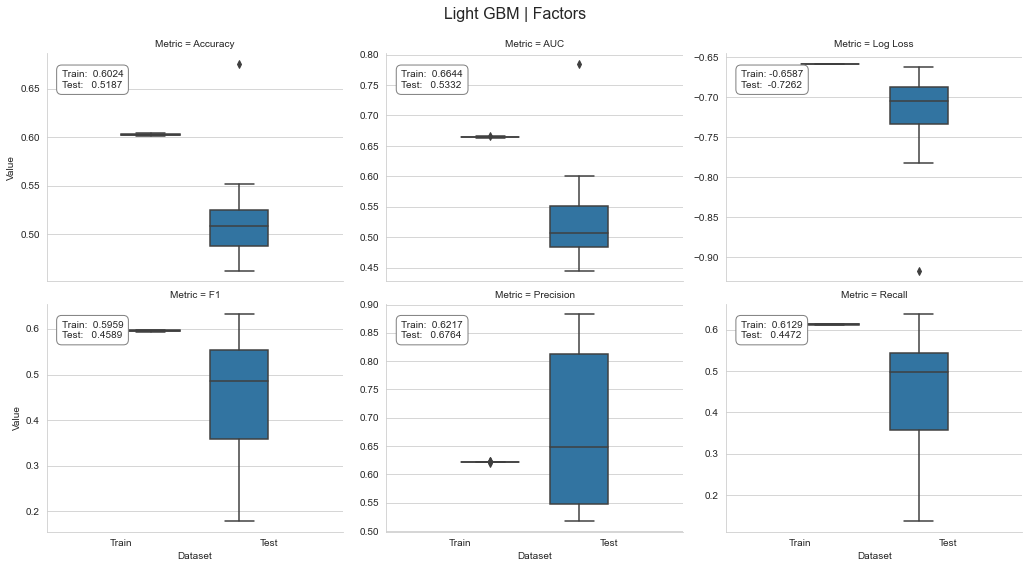

In [150]:
plot_result(lgb_factor_result, model='Light GBM | Factors')

#### Using dummy variables

In [61]:
algo = 'lgb_dummies'

In [62]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    lgb_dummy_cv_result, run_time[algo] = run_cv(lgb_clf)
    joblib.dump(lgb_dummy_cv_result, fname)
else:
    lgb_dummy_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed: 10.2min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 10.2min finished


##### Plot results

In [63]:
lgb_dummy_result = stack_results(lgb_dummy_cv_result)
lgb_dummy_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.525324,0.743517
Accuracy,0.512141,0.670014
F1,0.434198,0.676106
Log Loss,-0.704733,-0.600785
Precision,0.558771,0.688686
Recall,0.508796,0.684816


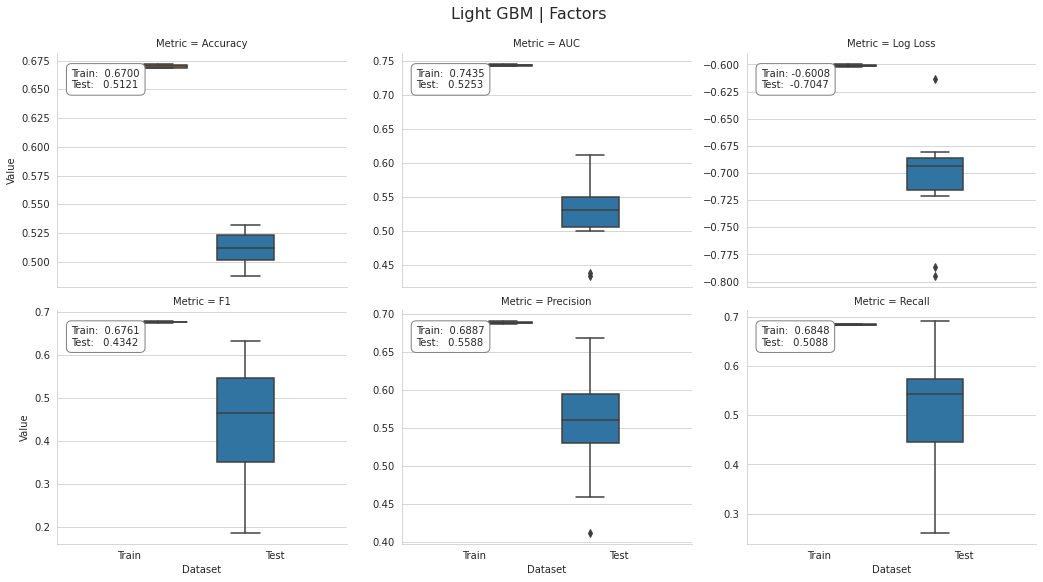

In [64]:
plot_result(lgb_dummy_result, model='Light GBM | Factors', fname=f'figures/{algo}_cv_result')

## Catboost

See CatBoost [docs](https://catboost.ai/docs/concepts/python-reference_catboostclassifier.html) for details on parameters and usage.

### CPU

#### Configure

In [151]:
cat_clf = CatBoostClassifier()

#### Cross-Validate

In [152]:
s = pd.Series(X_factors.columns.tolist())
cat_cols_idx = s[s.isin(cat_cols)].index.tolist()

NameError: name 'cat_cols' is not defined

Catboost requires integer values for categorical variables.

In [153]:
algo = 'catboost'

In [156]:
fname = results_path / f'i{algo}.joblib'
if not Path(fname).exists():
    cat_cv_result, run_time[algo] = run_cv(cat_clf,
                                           X=X_dummies,
                                           n_jobs=-1)
    joblib.dump(cat_cv_result, fname)
else:
    cat_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed: 14.2min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 14.3min finished


{'fit_time': array([  0.89519596,   0.89519596,   0.89519596,   0.89519596,
         0.89519596, 771.60670948,   0.89519596,   0.89519596,
       827.06686997, 831.17190361, 835.76962829, 792.91939354]), 'score_time': array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.14059949, 0.        , 0.        , 0.07810473, 0.07810569,
       0.4526155 , 0.16959858]), 'test_balanced_accuracy': array([       nan,        nan,        nan,        nan,        nan,
       0.55575896,        nan,        nan, 0.52970043, 0.57193562,
       0.44577114, 0.45386404]), 'train_balanced_accuracy': array([       nan,        nan,        nan,        nan,        nan,
       0.68036073,        nan,        nan, 0.68085643, 0.6809702 ,
       0.68070641, 0.68110685]), 'test_roc_auc': array([       nan,        nan,        nan,        nan,        nan,
       0.58161709,        nan,        nan, 0.59648063, 0.64267793,
       0.42217858, 0.44677996]), 'train_roc_auc': array([       nan,        na

#### Plot Results

In [157]:
cat_result = stack_results(cat_cv_result)
cat_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.537947,0.755056
Accuracy,0.511406,0.680800
F1,0.469847,0.682657
Log Loss,-0.738676,-0.597629
Precision,0.676187,0.685908
Recall,0.459557,0.685000


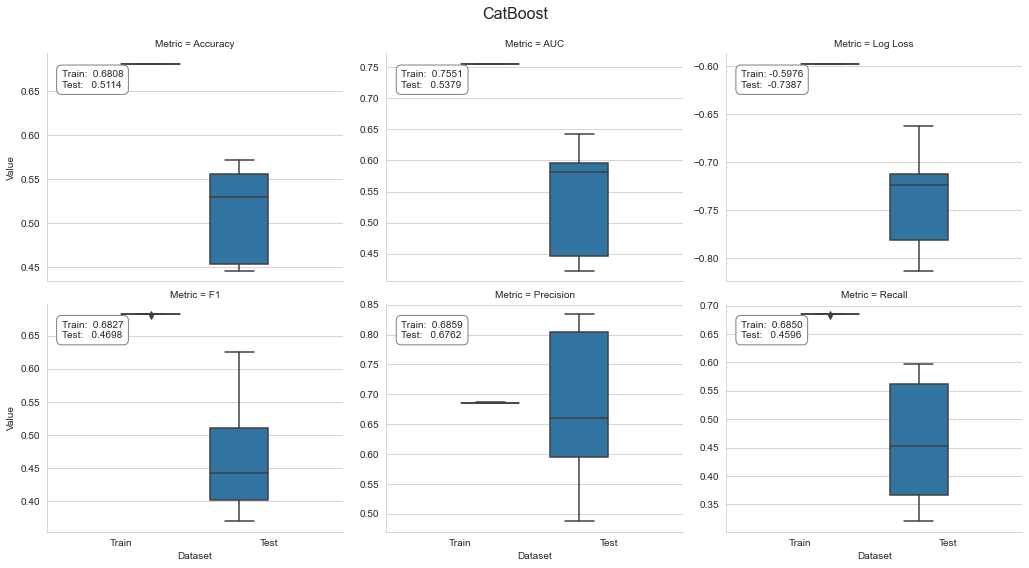

In [159]:
plot_result(cat_result, model='CatBoost')

### GPU

> Naturally, the following requires that you have a GPU.

#### Configure

In [160]:
cat_clf_gpu = CatBoostClassifier(task_type='GPU')

#### Cross-Validate

In [161]:
s = pd.Series(X_factors.columns.tolist())
cat_cols_idx = s[s.isin(cat_cols)].index.tolist()

NameError: name 'cat_cols' is not defined

In [162]:
algo = 'catboost_gpu'

In [163]:
fname = results_path / f'i{algo}.joblib'
if not Path(fname).exists():
    cat_gpu_cv_result, run_time[algo] = run_cv(cat_clf_gpu,
                                               y=y,
                                               X=X_dummies, 
                                               n_jobs=1)
    joblib.dump(cat_gpu_cv_result, fname)
else:
    cat_gpu_cv_result = joblib.load(fname)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Learning rate set to 0.023496
0:	learn: 0.6929283	total: 76.4ms	remaining: 1m 16s
1:	learn: 0.6927266	total: 129ms	remaining: 1m 4s
2:	learn: 0.6925264	total: 180ms	remaining: 59.8s
3:	learn: 0.6923415	total: 229ms	remaining: 56.9s
4:	learn: 0.6921504	total: 278ms	remaining: 55.2s
5:	learn: 0.6919632	total: 330ms	remaining: 54.7s
6:	learn: 0.6917708	total: 380ms	remaining: 53.9s
7:	learn: 0.6915947	total: 430ms	remaining: 53.3s
8:	learn: 0.6914405	total: 481ms	remaining: 52.9s
9:	learn: 0.6912620	total: 531ms	remaining: 52.5s
10:	learn: 0.6911040	total: 582ms	remaining: 52.3s
11:	learn: 0.6909273	total: 633ms	remaining: 52.1s
12:	learn: 0.6907631	total: 686ms	remaining: 52.1s
13:	learn: 0.6906118	total: 738ms	remaining: 52s
14:	learn: 0.6904638	total: 788ms	remaining: 51.7s
15:	learn: 0.6903074	total: 840ms	remaining: 51.6s
16:	learn: 0.6901632	total: 893ms	remaining: 51.6s
17:	learn: 0.6900154	total: 940ms	remaining: 51.3s
18:	learn: 0.6898762	total: 992ms	remaining: 51.2s
19:	learn: 

163:	learn: 0.6789498	total: 8.64s	remaining: 44s
164:	learn: 0.6788883	total: 8.69s	remaining: 44s
165:	learn: 0.6788471	total: 8.74s	remaining: 43.9s
166:	learn: 0.6788083	total: 8.8s	remaining: 43.9s
167:	learn: 0.6787437	total: 8.85s	remaining: 43.9s
168:	learn: 0.6787020	total: 8.91s	remaining: 43.8s
169:	learn: 0.6786528	total: 8.96s	remaining: 43.8s
170:	learn: 0.6786042	total: 9.02s	remaining: 43.7s
171:	learn: 0.6785500	total: 9.08s	remaining: 43.7s
172:	learn: 0.6784900	total: 9.13s	remaining: 43.7s
173:	learn: 0.6784330	total: 9.19s	remaining: 43.6s
174:	learn: 0.6783725	total: 9.25s	remaining: 43.6s
175:	learn: 0.6783231	total: 9.3s	remaining: 43.6s
176:	learn: 0.6782872	total: 9.36s	remaining: 43.5s
177:	learn: 0.6782374	total: 9.42s	remaining: 43.5s
178:	learn: 0.6781814	total: 9.47s	remaining: 43.4s
179:	learn: 0.6781193	total: 9.53s	remaining: 43.4s
180:	learn: 0.6780717	total: 9.59s	remaining: 43.4s
181:	learn: 0.6780257	total: 9.64s	remaining: 43.3s
182:	learn: 0.6779

325:	learn: 0.6721252	total: 17.6s	remaining: 36.5s
326:	learn: 0.6720793	total: 17.7s	remaining: 36.4s
327:	learn: 0.6720386	total: 17.8s	remaining: 36.4s
328:	learn: 0.6720087	total: 17.8s	remaining: 36.3s
329:	learn: 0.6719642	total: 17.9s	remaining: 36.3s
330:	learn: 0.6719390	total: 17.9s	remaining: 36.2s
331:	learn: 0.6719013	total: 18s	remaining: 36.2s
332:	learn: 0.6718771	total: 18s	remaining: 36.1s
333:	learn: 0.6718521	total: 18.1s	remaining: 36.1s
334:	learn: 0.6718262	total: 18.1s	remaining: 36s
335:	learn: 0.6717969	total: 18.2s	remaining: 36s
336:	learn: 0.6717672	total: 18.3s	remaining: 35.9s
337:	learn: 0.6717466	total: 18.3s	remaining: 35.8s
338:	learn: 0.6717119	total: 18.4s	remaining: 35.8s
339:	learn: 0.6716682	total: 18.4s	remaining: 35.7s
340:	learn: 0.6716349	total: 18.5s	remaining: 35.7s
341:	learn: 0.6716058	total: 18.5s	remaining: 35.6s
342:	learn: 0.6715801	total: 18.6s	remaining: 35.6s
343:	learn: 0.6715475	total: 18.6s	remaining: 35.5s
344:	learn: 0.671508

486:	learn: 0.6670635	total: 26.5s	remaining: 28s
487:	learn: 0.6670347	total: 26.6s	remaining: 27.9s
488:	learn: 0.6670079	total: 26.7s	remaining: 27.9s
489:	learn: 0.6669778	total: 26.7s	remaining: 27.8s
490:	learn: 0.6669386	total: 26.8s	remaining: 27.8s
491:	learn: 0.6669109	total: 26.8s	remaining: 27.7s
492:	learn: 0.6668747	total: 26.9s	remaining: 27.6s
493:	learn: 0.6668427	total: 26.9s	remaining: 27.6s
494:	learn: 0.6668159	total: 27s	remaining: 27.5s
495:	learn: 0.6667865	total: 27s	remaining: 27.5s
496:	learn: 0.6667592	total: 27.1s	remaining: 27.4s
497:	learn: 0.6667290	total: 27.2s	remaining: 27.4s
498:	learn: 0.6667053	total: 27.2s	remaining: 27.3s
499:	learn: 0.6666805	total: 27.3s	remaining: 27.3s
500:	learn: 0.6666522	total: 27.3s	remaining: 27.2s
501:	learn: 0.6666354	total: 27.4s	remaining: 27.2s
502:	learn: 0.6666168	total: 27.4s	remaining: 27.1s
503:	learn: 0.6665807	total: 27.5s	remaining: 27s
504:	learn: 0.6665438	total: 27.5s	remaining: 27s
505:	learn: 0.6665157	

647:	learn: 0.6626313	total: 35.6s	remaining: 19.3s
648:	learn: 0.6626061	total: 35.6s	remaining: 19.3s
649:	learn: 0.6625774	total: 35.7s	remaining: 19.2s
650:	learn: 0.6625624	total: 35.8s	remaining: 19.2s
651:	learn: 0.6625419	total: 35.8s	remaining: 19.1s
652:	learn: 0.6625102	total: 35.9s	remaining: 19.1s
653:	learn: 0.6624723	total: 35.9s	remaining: 19s
654:	learn: 0.6624495	total: 36s	remaining: 18.9s
655:	learn: 0.6624315	total: 36s	remaining: 18.9s
656:	learn: 0.6624120	total: 36.1s	remaining: 18.8s
657:	learn: 0.6623838	total: 36.1s	remaining: 18.8s
658:	learn: 0.6623614	total: 36.2s	remaining: 18.7s
659:	learn: 0.6623345	total: 36.2s	remaining: 18.7s
660:	learn: 0.6623128	total: 36.3s	remaining: 18.6s
661:	learn: 0.6622927	total: 36.4s	remaining: 18.6s
662:	learn: 0.6622640	total: 36.4s	remaining: 18.5s
663:	learn: 0.6622376	total: 36.5s	remaining: 18.5s
664:	learn: 0.6622118	total: 36.5s	remaining: 18.4s
665:	learn: 0.6621927	total: 36.6s	remaining: 18.3s
666:	learn: 0.6621

808:	learn: 0.6588853	total: 44.6s	remaining: 10.5s
809:	learn: 0.6588642	total: 44.7s	remaining: 10.5s
810:	learn: 0.6588449	total: 44.7s	remaining: 10.4s
811:	learn: 0.6588193	total: 44.8s	remaining: 10.4s
812:	learn: 0.6588017	total: 44.8s	remaining: 10.3s
813:	learn: 0.6587732	total: 44.9s	remaining: 10.3s
814:	learn: 0.6587553	total: 44.9s	remaining: 10.2s
815:	learn: 0.6587399	total: 45s	remaining: 10.1s
816:	learn: 0.6587175	total: 45.1s	remaining: 10.1s
817:	learn: 0.6586981	total: 45.1s	remaining: 10s
818:	learn: 0.6586740	total: 45.2s	remaining: 9.98s
819:	learn: 0.6586532	total: 45.2s	remaining: 9.93s
820:	learn: 0.6586318	total: 45.3s	remaining: 9.87s
821:	learn: 0.6586099	total: 45.3s	remaining: 9.81s
822:	learn: 0.6585910	total: 45.4s	remaining: 9.76s
823:	learn: 0.6585722	total: 45.4s	remaining: 9.71s
824:	learn: 0.6585538	total: 45.5s	remaining: 9.65s
825:	learn: 0.6585354	total: 45.5s	remaining: 9.59s
826:	learn: 0.6585118	total: 45.6s	remaining: 9.54s
827:	learn: 0.65

968:	learn: 0.6555446	total: 53.6s	remaining: 1.71s
969:	learn: 0.6555252	total: 53.7s	remaining: 1.66s
970:	learn: 0.6554955	total: 53.7s	remaining: 1.6s
971:	learn: 0.6554695	total: 53.8s	remaining: 1.55s
972:	learn: 0.6554533	total: 53.8s	remaining: 1.49s
973:	learn: 0.6554288	total: 53.9s	remaining: 1.44s
974:	learn: 0.6554145	total: 53.9s	remaining: 1.38s
975:	learn: 0.6553923	total: 54s	remaining: 1.33s
976:	learn: 0.6553778	total: 54.1s	remaining: 1.27s
977:	learn: 0.6553598	total: 54.1s	remaining: 1.22s
978:	learn: 0.6553387	total: 54.2s	remaining: 1.16s
979:	learn: 0.6553162	total: 54.2s	remaining: 1.11s
980:	learn: 0.6552961	total: 54.3s	remaining: 1.05s
981:	learn: 0.6552722	total: 54.3s	remaining: 996ms
982:	learn: 0.6552583	total: 54.4s	remaining: 941ms
983:	learn: 0.6552337	total: 54.5s	remaining: 886ms
984:	learn: 0.6552087	total: 54.5s	remaining: 830ms
985:	learn: 0.6551860	total: 54.6s	remaining: 775ms
986:	learn: 0.6551595	total: 54.6s	remaining: 720ms
987:	learn: 0.6

130:	learn: 0.6808756	total: 7.29s	remaining: 48.4s
131:	learn: 0.6808354	total: 7.34s	remaining: 48.3s
132:	learn: 0.6807665	total: 7.4s	remaining: 48.2s
133:	learn: 0.6807133	total: 7.46s	remaining: 48.2s
134:	learn: 0.6806417	total: 7.51s	remaining: 48.1s
135:	learn: 0.6805708	total: 7.57s	remaining: 48.1s
136:	learn: 0.6804952	total: 7.62s	remaining: 48s
137:	learn: 0.6804288	total: 7.68s	remaining: 48s
138:	learn: 0.6803763	total: 7.74s	remaining: 47.9s
139:	learn: 0.6803198	total: 7.8s	remaining: 47.9s
140:	learn: 0.6802643	total: 7.86s	remaining: 47.9s
141:	learn: 0.6802161	total: 7.91s	remaining: 47.8s
142:	learn: 0.6801458	total: 7.96s	remaining: 47.7s
143:	learn: 0.6801001	total: 8.01s	remaining: 47.6s
144:	learn: 0.6800456	total: 8.07s	remaining: 47.6s
145:	learn: 0.6799928	total: 8.12s	remaining: 47.5s
146:	learn: 0.6799285	total: 8.18s	remaining: 47.4s
147:	learn: 0.6798788	total: 8.23s	remaining: 47.4s
148:	learn: 0.6798205	total: 8.29s	remaining: 47.3s
149:	learn: 0.6797

290:	learn: 0.6734844	total: 16.2s	remaining: 39.4s
291:	learn: 0.6734462	total: 16.2s	remaining: 39.4s
292:	learn: 0.6734114	total: 16.3s	remaining: 39.3s
293:	learn: 0.6733749	total: 16.3s	remaining: 39.2s
294:	learn: 0.6733467	total: 16.4s	remaining: 39.2s
295:	learn: 0.6733115	total: 16.5s	remaining: 39.1s
296:	learn: 0.6732810	total: 16.5s	remaining: 39.1s
297:	learn: 0.6732416	total: 16.6s	remaining: 39s
298:	learn: 0.6731867	total: 16.6s	remaining: 39s
299:	learn: 0.6731395	total: 16.7s	remaining: 38.9s
300:	learn: 0.6730950	total: 16.7s	remaining: 38.8s
301:	learn: 0.6730534	total: 16.8s	remaining: 38.8s
302:	learn: 0.6730148	total: 16.8s	remaining: 38.7s
303:	learn: 0.6729825	total: 16.9s	remaining: 38.7s
304:	learn: 0.6729501	total: 17s	remaining: 38.6s
305:	learn: 0.6729088	total: 17s	remaining: 38.6s
306:	learn: 0.6728811	total: 17.1s	remaining: 38.5s
307:	learn: 0.6728442	total: 17.1s	remaining: 38.5s
308:	learn: 0.6728231	total: 17.2s	remaining: 38.4s
309:	learn: 0.672782

450:	learn: 0.6680758	total: 25s	remaining: 30.5s
451:	learn: 0.6680554	total: 25.1s	remaining: 30.4s
452:	learn: 0.6680316	total: 25.1s	remaining: 30.3s
453:	learn: 0.6680145	total: 25.2s	remaining: 30.3s
454:	learn: 0.6679856	total: 25.2s	remaining: 30.2s
455:	learn: 0.6679637	total: 25.3s	remaining: 30.2s
456:	learn: 0.6679406	total: 25.3s	remaining: 30.1s
457:	learn: 0.6679193	total: 25.4s	remaining: 30.1s
458:	learn: 0.6678832	total: 25.5s	remaining: 30s
459:	learn: 0.6678519	total: 25.5s	remaining: 29.9s
460:	learn: 0.6678299	total: 25.6s	remaining: 29.9s
461:	learn: 0.6677949	total: 25.6s	remaining: 29.8s
462:	learn: 0.6677627	total: 25.7s	remaining: 29.8s
463:	learn: 0.6677377	total: 25.7s	remaining: 29.7s
464:	learn: 0.6677078	total: 25.8s	remaining: 29.7s
465:	learn: 0.6676809	total: 25.8s	remaining: 29.6s
466:	learn: 0.6676325	total: 25.9s	remaining: 29.6s
467:	learn: 0.6676059	total: 26s	remaining: 29.5s
468:	learn: 0.6675532	total: 26s	remaining: 29.5s
469:	learn: 0.667524

610:	learn: 0.6635814	total: 34s	remaining: 21.6s
611:	learn: 0.6635563	total: 34s	remaining: 21.6s
612:	learn: 0.6635358	total: 34.1s	remaining: 21.5s
613:	learn: 0.6635114	total: 34.1s	remaining: 21.4s
614:	learn: 0.6634854	total: 34.2s	remaining: 21.4s
615:	learn: 0.6634512	total: 34.2s	remaining: 21.3s
616:	learn: 0.6634186	total: 34.3s	remaining: 21.3s
617:	learn: 0.6633852	total: 34.3s	remaining: 21.2s
618:	learn: 0.6633590	total: 34.4s	remaining: 21.2s
619:	learn: 0.6633355	total: 34.4s	remaining: 21.1s
620:	learn: 0.6633016	total: 34.5s	remaining: 21.1s
621:	learn: 0.6632849	total: 34.6s	remaining: 21s
622:	learn: 0.6632523	total: 34.6s	remaining: 20.9s
623:	learn: 0.6632215	total: 34.7s	remaining: 20.9s
624:	learn: 0.6632038	total: 34.7s	remaining: 20.8s
625:	learn: 0.6631812	total: 34.8s	remaining: 20.8s
626:	learn: 0.6631504	total: 34.8s	remaining: 20.7s
627:	learn: 0.6631330	total: 34.9s	remaining: 20.7s
628:	learn: 0.6631059	total: 34.9s	remaining: 20.6s
629:	learn: 0.6630

772:	learn: 0.6595642	total: 43.1s	remaining: 12.6s
773:	learn: 0.6595397	total: 43.1s	remaining: 12.6s
774:	learn: 0.6595139	total: 43.2s	remaining: 12.5s
775:	learn: 0.6594879	total: 43.2s	remaining: 12.5s
776:	learn: 0.6594633	total: 43.3s	remaining: 12.4s
777:	learn: 0.6594397	total: 43.4s	remaining: 12.4s
778:	learn: 0.6594189	total: 43.4s	remaining: 12.3s
779:	learn: 0.6593939	total: 43.5s	remaining: 12.3s
780:	learn: 0.6593752	total: 43.5s	remaining: 12.2s
781:	learn: 0.6593524	total: 43.6s	remaining: 12.2s
782:	learn: 0.6593303	total: 43.6s	remaining: 12.1s
783:	learn: 0.6593087	total: 43.7s	remaining: 12s
784:	learn: 0.6592918	total: 43.8s	remaining: 12s
785:	learn: 0.6592740	total: 43.8s	remaining: 11.9s
786:	learn: 0.6592512	total: 43.9s	remaining: 11.9s
787:	learn: 0.6592289	total: 43.9s	remaining: 11.8s
788:	learn: 0.6592064	total: 44s	remaining: 11.8s
789:	learn: 0.6591847	total: 44s	remaining: 11.7s
790:	learn: 0.6591610	total: 44.1s	remaining: 11.6s
791:	learn: 0.659143

933:	learn: 0.6559910	total: 52.1s	remaining: 3.68s
934:	learn: 0.6559684	total: 52.1s	remaining: 3.62s
935:	learn: 0.6559533	total: 52.2s	remaining: 3.57s
936:	learn: 0.6559339	total: 52.2s	remaining: 3.51s
937:	learn: 0.6559113	total: 52.3s	remaining: 3.46s
938:	learn: 0.6558915	total: 52.3s	remaining: 3.4s
939:	learn: 0.6558671	total: 52.4s	remaining: 3.34s
940:	learn: 0.6558383	total: 52.5s	remaining: 3.29s
941:	learn: 0.6558227	total: 52.5s	remaining: 3.23s
942:	learn: 0.6558016	total: 52.6s	remaining: 3.18s
943:	learn: 0.6557771	total: 52.6s	remaining: 3.12s
944:	learn: 0.6557574	total: 52.7s	remaining: 3.07s
945:	learn: 0.6557418	total: 52.7s	remaining: 3.01s
946:	learn: 0.6557250	total: 52.8s	remaining: 2.95s
947:	learn: 0.6557065	total: 52.8s	remaining: 2.9s
948:	learn: 0.6556834	total: 52.9s	remaining: 2.84s
949:	learn: 0.6556689	total: 53s	remaining: 2.79s
950:	learn: 0.6556525	total: 53s	remaining: 2.73s
951:	learn: 0.6556315	total: 53.1s	remaining: 2.67s
952:	learn: 0.6556

96:	learn: 0.6830222	total: 5.37s	remaining: 50s
97:	learn: 0.6829656	total: 5.42s	remaining: 49.9s
98:	learn: 0.6829071	total: 5.48s	remaining: 49.9s
99:	learn: 0.6828453	total: 5.55s	remaining: 49.9s
100:	learn: 0.6827865	total: 5.6s	remaining: 49.9s
101:	learn: 0.6827165	total: 5.67s	remaining: 49.9s
102:	learn: 0.6826686	total: 5.72s	remaining: 49.8s
103:	learn: 0.6826086	total: 5.78s	remaining: 49.8s
104:	learn: 0.6825522	total: 5.83s	remaining: 49.7s
105:	learn: 0.6824765	total: 5.89s	remaining: 49.6s
106:	learn: 0.6824031	total: 5.94s	remaining: 49.6s
107:	learn: 0.6823382	total: 6s	remaining: 49.5s
108:	learn: 0.6822791	total: 6.05s	remaining: 49.5s
109:	learn: 0.6822044	total: 6.11s	remaining: 49.5s
110:	learn: 0.6821408	total: 6.17s	remaining: 49.4s
111:	learn: 0.6820649	total: 6.23s	remaining: 49.4s
112:	learn: 0.6820020	total: 6.29s	remaining: 49.3s
113:	learn: 0.6819521	total: 6.34s	remaining: 49.3s
114:	learn: 0.6818735	total: 6.4s	remaining: 49.2s
115:	learn: 0.6818266	t

256:	learn: 0.6748808	total: 14.3s	remaining: 41.3s
257:	learn: 0.6748442	total: 14.4s	remaining: 41.3s
258:	learn: 0.6748067	total: 14.4s	remaining: 41.2s
259:	learn: 0.6747777	total: 14.5s	remaining: 41.2s
260:	learn: 0.6747318	total: 14.5s	remaining: 41.1s
261:	learn: 0.6746943	total: 14.6s	remaining: 41s
262:	learn: 0.6746588	total: 14.6s	remaining: 41s
263:	learn: 0.6746224	total: 14.7s	remaining: 40.9s
264:	learn: 0.6745835	total: 14.7s	remaining: 40.9s
265:	learn: 0.6745360	total: 14.8s	remaining: 40.8s
266:	learn: 0.6744840	total: 14.9s	remaining: 40.8s
267:	learn: 0.6744578	total: 14.9s	remaining: 40.7s
268:	learn: 0.6744247	total: 15s	remaining: 40.7s
269:	learn: 0.6743837	total: 15s	remaining: 40.6s
270:	learn: 0.6743474	total: 15.1s	remaining: 40.5s
271:	learn: 0.6743098	total: 15.1s	remaining: 40.5s
272:	learn: 0.6742700	total: 15.2s	remaining: 40.4s
273:	learn: 0.6742416	total: 15.2s	remaining: 40.4s
274:	learn: 0.6742130	total: 15.3s	remaining: 40.3s
275:	learn: 0.674177

415:	learn: 0.6692118	total: 23s	remaining: 32.3s
416:	learn: 0.6691863	total: 23.1s	remaining: 32.3s
417:	learn: 0.6691539	total: 23.1s	remaining: 32.2s
418:	learn: 0.6691142	total: 23.2s	remaining: 32.1s
419:	learn: 0.6690839	total: 23.2s	remaining: 32.1s
420:	learn: 0.6690605	total: 23.3s	remaining: 32s
421:	learn: 0.6690223	total: 23.4s	remaining: 32s
422:	learn: 0.6689971	total: 23.4s	remaining: 31.9s
423:	learn: 0.6689607	total: 23.5s	remaining: 31.9s
424:	learn: 0.6689377	total: 23.5s	remaining: 31.8s
425:	learn: 0.6689145	total: 23.6s	remaining: 31.8s
426:	learn: 0.6688830	total: 23.6s	remaining: 31.7s
427:	learn: 0.6688494	total: 23.7s	remaining: 31.7s
428:	learn: 0.6688267	total: 23.7s	remaining: 31.6s
429:	learn: 0.6687836	total: 23.8s	remaining: 31.6s
430:	learn: 0.6687556	total: 23.9s	remaining: 31.5s
431:	learn: 0.6687236	total: 23.9s	remaining: 31.4s
432:	learn: 0.6686957	total: 24s	remaining: 31.4s
433:	learn: 0.6686595	total: 24s	remaining: 31.3s
434:	learn: 0.6686265	

576:	learn: 0.6645973	total: 31.9s	remaining: 23.4s
577:	learn: 0.6645685	total: 32s	remaining: 23.4s
578:	learn: 0.6645438	total: 32.1s	remaining: 23.3s
579:	learn: 0.6645217	total: 32.1s	remaining: 23.3s
580:	learn: 0.6644985	total: 32.2s	remaining: 23.2s
581:	learn: 0.6644698	total: 32.2s	remaining: 23.1s
582:	learn: 0.6644380	total: 32.3s	remaining: 23.1s
583:	learn: 0.6644089	total: 32.3s	remaining: 23s
584:	learn: 0.6643866	total: 32.4s	remaining: 23s
585:	learn: 0.6643601	total: 32.4s	remaining: 22.9s
586:	learn: 0.6643367	total: 32.5s	remaining: 22.9s
587:	learn: 0.6643080	total: 32.6s	remaining: 22.8s
588:	learn: 0.6642760	total: 32.6s	remaining: 22.8s
589:	learn: 0.6642533	total: 32.7s	remaining: 22.7s
590:	learn: 0.6642250	total: 32.7s	remaining: 22.6s
591:	learn: 0.6642072	total: 32.8s	remaining: 22.6s
592:	learn: 0.6641788	total: 32.8s	remaining: 22.5s
593:	learn: 0.6641470	total: 32.9s	remaining: 22.5s
594:	learn: 0.6641296	total: 33s	remaining: 22.4s
595:	learn: 0.664099

738:	learn: 0.6604788	total: 40.9s	remaining: 14.5s
739:	learn: 0.6604588	total: 41s	remaining: 14.4s
740:	learn: 0.6604319	total: 41s	remaining: 14.3s
741:	learn: 0.6604004	total: 41.1s	remaining: 14.3s
742:	learn: 0.6603778	total: 41.2s	remaining: 14.2s
743:	learn: 0.6603584	total: 41.2s	remaining: 14.2s
744:	learn: 0.6603292	total: 41.3s	remaining: 14.1s
745:	learn: 0.6603091	total: 41.3s	remaining: 14.1s
746:	learn: 0.6602836	total: 41.4s	remaining: 14s
747:	learn: 0.6602530	total: 41.4s	remaining: 14s
748:	learn: 0.6602254	total: 41.5s	remaining: 13.9s
749:	learn: 0.6602043	total: 41.6s	remaining: 13.9s
750:	learn: 0.6601822	total: 41.6s	remaining: 13.8s
751:	learn: 0.6601541	total: 41.7s	remaining: 13.7s
752:	learn: 0.6601300	total: 41.7s	remaining: 13.7s
753:	learn: 0.6601030	total: 41.8s	remaining: 13.6s
754:	learn: 0.6600809	total: 41.8s	remaining: 13.6s
755:	learn: 0.6600577	total: 41.9s	remaining: 13.5s
756:	learn: 0.6600318	total: 41.9s	remaining: 13.5s
757:	learn: 0.660005

898:	learn: 0.6569096	total: 49.8s	remaining: 5.6s
899:	learn: 0.6568849	total: 49.9s	remaining: 5.54s
900:	learn: 0.6568636	total: 49.9s	remaining: 5.49s
901:	learn: 0.6568464	total: 50s	remaining: 5.43s
902:	learn: 0.6568197	total: 50s	remaining: 5.38s
903:	learn: 0.6567969	total: 50.1s	remaining: 5.32s
904:	learn: 0.6567762	total: 50.1s	remaining: 5.26s
905:	learn: 0.6567485	total: 50.2s	remaining: 5.21s
906:	learn: 0.6567329	total: 50.3s	remaining: 5.15s
907:	learn: 0.6567133	total: 50.3s	remaining: 5.1s
908:	learn: 0.6566954	total: 50.4s	remaining: 5.04s
909:	learn: 0.6566763	total: 50.4s	remaining: 4.99s
910:	learn: 0.6566527	total: 50.5s	remaining: 4.93s
911:	learn: 0.6566346	total: 50.5s	remaining: 4.88s
912:	learn: 0.6566196	total: 50.6s	remaining: 4.82s
913:	learn: 0.6566007	total: 50.6s	remaining: 4.76s
914:	learn: 0.6565793	total: 50.7s	remaining: 4.71s
915:	learn: 0.6565568	total: 50.7s	remaining: 4.65s
916:	learn: 0.6565365	total: 50.8s	remaining: 4.6s
917:	learn: 0.65651

60:	learn: 0.6853957	total: 4.32s	remaining: 1m 6s
61:	learn: 0.6853174	total: 4.39s	remaining: 1m 6s
62:	learn: 0.6852370	total: 4.47s	remaining: 1m 6s
63:	learn: 0.6851466	total: 4.55s	remaining: 1m 6s
64:	learn: 0.6850816	total: 4.61s	remaining: 1m 6s
65:	learn: 0.6849953	total: 4.69s	remaining: 1m 6s
66:	learn: 0.6849118	total: 4.76s	remaining: 1m 6s
67:	learn: 0.6848332	total: 4.83s	remaining: 1m 6s
68:	learn: 0.6847446	total: 4.89s	remaining: 1m 6s
69:	learn: 0.6846633	total: 4.97s	remaining: 1m 6s
70:	learn: 0.6845923	total: 5.04s	remaining: 1m 5s
71:	learn: 0.6845173	total: 5.12s	remaining: 1m 5s
72:	learn: 0.6844588	total: 5.19s	remaining: 1m 5s
73:	learn: 0.6843810	total: 5.27s	remaining: 1m 5s
74:	learn: 0.6843224	total: 5.35s	remaining: 1m 5s
75:	learn: 0.6842455	total: 5.42s	remaining: 1m 5s
76:	learn: 0.6841559	total: 5.5s	remaining: 1m 5s
77:	learn: 0.6840698	total: 5.58s	remaining: 1m 5s
78:	learn: 0.6840029	total: 5.65s	remaining: 1m 5s
79:	learn: 0.6839221	total: 5.73

220:	learn: 0.6761421	total: 14.4s	remaining: 50.8s
221:	learn: 0.6761052	total: 14.5s	remaining: 50.7s
222:	learn: 0.6760675	total: 14.5s	remaining: 50.6s
223:	learn: 0.6760129	total: 14.6s	remaining: 50.5s
224:	learn: 0.6759681	total: 14.6s	remaining: 50.4s
225:	learn: 0.6759244	total: 14.7s	remaining: 50.3s
226:	learn: 0.6758961	total: 14.7s	remaining: 50.2s
227:	learn: 0.6758525	total: 14.8s	remaining: 50.1s
228:	learn: 0.6758103	total: 14.9s	remaining: 50.1s
229:	learn: 0.6757525	total: 14.9s	remaining: 50s
230:	learn: 0.6757162	total: 15s	remaining: 49.9s
231:	learn: 0.6756759	total: 15.1s	remaining: 49.9s
232:	learn: 0.6756361	total: 15.1s	remaining: 49.7s
233:	learn: 0.6755975	total: 15.2s	remaining: 49.6s
234:	learn: 0.6755591	total: 15.2s	remaining: 49.5s
235:	learn: 0.6755129	total: 15.3s	remaining: 49.4s
236:	learn: 0.6754778	total: 15.3s	remaining: 49.3s
237:	learn: 0.6754270	total: 15.4s	remaining: 49.2s
238:	learn: 0.6753741	total: 15.4s	remaining: 49.1s
239:	learn: 0.67

381:	learn: 0.6700600	total: 24.5s	remaining: 39.6s
382:	learn: 0.6700296	total: 24.5s	remaining: 39.5s
383:	learn: 0.6700071	total: 24.6s	remaining: 39.4s
384:	learn: 0.6699744	total: 24.6s	remaining: 39.4s
385:	learn: 0.6699334	total: 24.7s	remaining: 39.3s
386:	learn: 0.6699080	total: 24.8s	remaining: 39.2s
387:	learn: 0.6698812	total: 24.8s	remaining: 39.2s
388:	learn: 0.6698450	total: 24.9s	remaining: 39.1s
389:	learn: 0.6698168	total: 25s	remaining: 39s
390:	learn: 0.6697900	total: 25s	remaining: 39s
391:	learn: 0.6697462	total: 25.1s	remaining: 38.9s
392:	learn: 0.6697151	total: 25.2s	remaining: 38.9s
393:	learn: 0.6696820	total: 25.3s	remaining: 38.9s
394:	learn: 0.6696499	total: 25.3s	remaining: 38.8s
395:	learn: 0.6696169	total: 25.4s	remaining: 38.7s
396:	learn: 0.6695825	total: 25.4s	remaining: 38.6s
397:	learn: 0.6695538	total: 25.5s	remaining: 38.6s
398:	learn: 0.6695176	total: 25.5s	remaining: 38.5s
399:	learn: 0.6694918	total: 25.6s	remaining: 38.4s
400:	learn: 0.669448

543:	learn: 0.6652500	total: 34.5s	remaining: 28.9s
544:	learn: 0.6652208	total: 34.5s	remaining: 28.8s
545:	learn: 0.6651813	total: 34.6s	remaining: 28.8s
546:	learn: 0.6651551	total: 34.6s	remaining: 28.7s
547:	learn: 0.6651211	total: 34.7s	remaining: 28.6s
548:	learn: 0.6650877	total: 34.8s	remaining: 28.6s
549:	learn: 0.6650637	total: 34.8s	remaining: 28.5s
550:	learn: 0.6650461	total: 34.9s	remaining: 28.4s
551:	learn: 0.6650145	total: 34.9s	remaining: 28.3s
552:	learn: 0.6649899	total: 35s	remaining: 28.3s
553:	learn: 0.6649547	total: 35s	remaining: 28.2s
554:	learn: 0.6649261	total: 35.1s	remaining: 28.1s
555:	learn: 0.6649077	total: 35.1s	remaining: 28.1s
556:	learn: 0.6648772	total: 35.2s	remaining: 28s
557:	learn: 0.6648511	total: 35.3s	remaining: 27.9s
558:	learn: 0.6648330	total: 35.3s	remaining: 27.9s
559:	learn: 0.6648012	total: 35.4s	remaining: 27.8s
560:	learn: 0.6647769	total: 35.4s	remaining: 27.7s
561:	learn: 0.6647549	total: 35.5s	remaining: 27.6s
562:	learn: 0.6647

703:	learn: 0.6611006	total: 43.2s	remaining: 18.2s
704:	learn: 0.6610798	total: 43.3s	remaining: 18.1s
705:	learn: 0.6610574	total: 43.4s	remaining: 18.1s
706:	learn: 0.6610343	total: 43.4s	remaining: 18s
707:	learn: 0.6610082	total: 43.5s	remaining: 17.9s
708:	learn: 0.6609844	total: 43.5s	remaining: 17.9s
709:	learn: 0.6609538	total: 43.6s	remaining: 17.8s
710:	learn: 0.6609330	total: 43.6s	remaining: 17.7s
711:	learn: 0.6609081	total: 43.7s	remaining: 17.7s
712:	learn: 0.6608857	total: 43.7s	remaining: 17.6s
713:	learn: 0.6608674	total: 43.8s	remaining: 17.5s
714:	learn: 0.6608328	total: 43.8s	remaining: 17.5s
715:	learn: 0.6608023	total: 43.9s	remaining: 17.4s
716:	learn: 0.6607814	total: 44s	remaining: 17.4s
717:	learn: 0.6607577	total: 44s	remaining: 17.3s
718:	learn: 0.6607306	total: 44.1s	remaining: 17.2s
719:	learn: 0.6607061	total: 44.1s	remaining: 17.2s
720:	learn: 0.6606839	total: 44.2s	remaining: 17.1s
721:	learn: 0.6606584	total: 44.2s	remaining: 17s
722:	learn: 0.660639

865:	learn: 0.6573334	total: 51.9s	remaining: 8.03s
866:	learn: 0.6573161	total: 52s	remaining: 7.97s
867:	learn: 0.6572855	total: 52s	remaining: 7.91s
868:	learn: 0.6572697	total: 52.1s	remaining: 7.85s
869:	learn: 0.6572480	total: 52.1s	remaining: 7.79s
870:	learn: 0.6572243	total: 52.2s	remaining: 7.73s
871:	learn: 0.6572074	total: 52.2s	remaining: 7.66s
872:	learn: 0.6571850	total: 52.3s	remaining: 7.6s
873:	learn: 0.6571562	total: 52.3s	remaining: 7.54s
874:	learn: 0.6571364	total: 52.4s	remaining: 7.48s
875:	learn: 0.6571130	total: 52.4s	remaining: 7.42s
876:	learn: 0.6570911	total: 52.5s	remaining: 7.36s
877:	learn: 0.6570721	total: 52.5s	remaining: 7.3s
878:	learn: 0.6570475	total: 52.6s	remaining: 7.24s
879:	learn: 0.6570293	total: 52.6s	remaining: 7.18s
880:	learn: 0.6570105	total: 52.7s	remaining: 7.12s
881:	learn: 0.6569921	total: 52.7s	remaining: 7.06s
882:	learn: 0.6569621	total: 52.8s	remaining: 7s
883:	learn: 0.6569411	total: 52.9s	remaining: 6.93s
884:	learn: 0.6569215

24:	learn: 0.6891024	total: 1.41s	remaining: 54.9s
25:	learn: 0.6889780	total: 1.46s	remaining: 54.9s
26:	learn: 0.6888549	total: 1.52s	remaining: 54.8s
27:	learn: 0.6887369	total: 1.58s	remaining: 54.8s
28:	learn: 0.6886137	total: 1.64s	remaining: 54.8s
29:	learn: 0.6885215	total: 1.69s	remaining: 54.8s
30:	learn: 0.6883976	total: 1.75s	remaining: 54.8s
31:	learn: 0.6882739	total: 1.81s	remaining: 54.6s
32:	learn: 0.6881613	total: 1.86s	remaining: 54.7s
33:	learn: 0.6880383	total: 1.92s	remaining: 54.7s
34:	learn: 0.6879456	total: 1.98s	remaining: 54.6s
35:	learn: 0.6878392	total: 2.04s	remaining: 54.7s
36:	learn: 0.6877321	total: 2.1s	remaining: 54.6s
37:	learn: 0.6876316	total: 2.15s	remaining: 54.6s
38:	learn: 0.6875240	total: 2.21s	remaining: 54.6s
39:	learn: 0.6874173	total: 2.28s	remaining: 54.6s
40:	learn: 0.6873176	total: 2.33s	remaining: 54.6s
41:	learn: 0.6872201	total: 2.39s	remaining: 54.5s
42:	learn: 0.6871259	total: 2.45s	remaining: 54.5s
43:	learn: 0.6870147	total: 2.5s

188:	learn: 0.6778628	total: 10.6s	remaining: 45.4s
189:	learn: 0.6778130	total: 10.6s	remaining: 45.3s
190:	learn: 0.6777628	total: 10.7s	remaining: 45.3s
191:	learn: 0.6777323	total: 10.7s	remaining: 45.2s
192:	learn: 0.6776730	total: 10.8s	remaining: 45.1s
193:	learn: 0.6776168	total: 10.8s	remaining: 45.1s
194:	learn: 0.6775726	total: 10.9s	remaining: 45s
195:	learn: 0.6775296	total: 11s	remaining: 44.9s
196:	learn: 0.6774830	total: 11s	remaining: 44.9s
197:	learn: 0.6774261	total: 11.1s	remaining: 44.8s
198:	learn: 0.6773776	total: 11.1s	remaining: 44.7s
199:	learn: 0.6773293	total: 11.2s	remaining: 44.7s
200:	learn: 0.6772767	total: 11.2s	remaining: 44.6s
201:	learn: 0.6772438	total: 11.3s	remaining: 44.6s
202:	learn: 0.6771976	total: 11.3s	remaining: 44.5s
203:	learn: 0.6771562	total: 11.4s	remaining: 44.4s
204:	learn: 0.6771083	total: 11.4s	remaining: 44.4s
205:	learn: 0.6770651	total: 11.5s	remaining: 44.3s
206:	learn: 0.6770050	total: 11.5s	remaining: 44.2s
207:	learn: 0.6769

349:	learn: 0.6713741	total: 19.4s	remaining: 36s
350:	learn: 0.6713448	total: 19.5s	remaining: 36s
351:	learn: 0.6713148	total: 19.5s	remaining: 35.9s
352:	learn: 0.6712772	total: 19.6s	remaining: 35.9s
353:	learn: 0.6712430	total: 19.6s	remaining: 35.8s
354:	learn: 0.6712035	total: 19.7s	remaining: 35.8s
355:	learn: 0.6711738	total: 19.7s	remaining: 35.7s
356:	learn: 0.6711420	total: 19.8s	remaining: 35.7s
357:	learn: 0.6711140	total: 19.9s	remaining: 35.6s
358:	learn: 0.6710606	total: 19.9s	remaining: 35.6s
359:	learn: 0.6710351	total: 20s	remaining: 35.5s
360:	learn: 0.6710083	total: 20s	remaining: 35.4s
361:	learn: 0.6709708	total: 20.1s	remaining: 35.4s
362:	learn: 0.6709399	total: 20.1s	remaining: 35.3s
363:	learn: 0.6709056	total: 20.2s	remaining: 35.3s
364:	learn: 0.6708720	total: 20.2s	remaining: 35.2s
365:	learn: 0.6708316	total: 20.3s	remaining: 35.2s
366:	learn: 0.6708049	total: 20.4s	remaining: 35.1s
367:	learn: 0.6707683	total: 20.4s	remaining: 35s
368:	learn: 0.6707329	

509:	learn: 0.6663086	total: 28.3s	remaining: 27.2s
510:	learn: 0.6662734	total: 28.3s	remaining: 27.1s
511:	learn: 0.6662499	total: 28.4s	remaining: 27s
512:	learn: 0.6662128	total: 28.4s	remaining: 27s
513:	learn: 0.6661895	total: 28.5s	remaining: 26.9s
514:	learn: 0.6661648	total: 28.5s	remaining: 26.9s
515:	learn: 0.6661440	total: 28.6s	remaining: 26.8s
516:	learn: 0.6661182	total: 28.6s	remaining: 26.7s
517:	learn: 0.6660853	total: 28.7s	remaining: 26.7s
518:	learn: 0.6660644	total: 28.7s	remaining: 26.6s
519:	learn: 0.6660371	total: 28.8s	remaining: 26.6s
520:	learn: 0.6660024	total: 28.9s	remaining: 26.5s
521:	learn: 0.6659808	total: 28.9s	remaining: 26.5s
522:	learn: 0.6659551	total: 29s	remaining: 26.4s
523:	learn: 0.6659226	total: 29s	remaining: 26.4s
524:	learn: 0.6658961	total: 29.1s	remaining: 26.3s
525:	learn: 0.6658546	total: 29.1s	remaining: 26.3s
526:	learn: 0.6658311	total: 29.2s	remaining: 26.2s
527:	learn: 0.6658032	total: 29.2s	remaining: 26.1s
528:	learn: 0.665772

670:	learn: 0.6620264	total: 37.2s	remaining: 18.2s
671:	learn: 0.6620087	total: 37.2s	remaining: 18.2s
672:	learn: 0.6619807	total: 37.3s	remaining: 18.1s
673:	learn: 0.6619506	total: 37.3s	remaining: 18.1s
674:	learn: 0.6619245	total: 37.4s	remaining: 18s
675:	learn: 0.6619010	total: 37.5s	remaining: 17.9s
676:	learn: 0.6618769	total: 37.5s	remaining: 17.9s
677:	learn: 0.6618565	total: 37.6s	remaining: 17.8s
678:	learn: 0.6618297	total: 37.6s	remaining: 17.8s
679:	learn: 0.6618065	total: 37.7s	remaining: 17.7s
680:	learn: 0.6617821	total: 37.7s	remaining: 17.7s
681:	learn: 0.6617640	total: 37.8s	remaining: 17.6s
682:	learn: 0.6617433	total: 37.9s	remaining: 17.6s
683:	learn: 0.6617111	total: 37.9s	remaining: 17.5s
684:	learn: 0.6616839	total: 38s	remaining: 17.5s
685:	learn: 0.6616632	total: 38s	remaining: 17.4s
686:	learn: 0.6616451	total: 38.1s	remaining: 17.3s
687:	learn: 0.6616217	total: 38.1s	remaining: 17.3s
688:	learn: 0.6615848	total: 38.2s	remaining: 17.2s
689:	learn: 0.6615

829:	learn: 0.6582960	total: 45.8s	remaining: 9.38s
830:	learn: 0.6582722	total: 45.8s	remaining: 9.32s
831:	learn: 0.6582513	total: 45.9s	remaining: 9.27s
832:	learn: 0.6582349	total: 45.9s	remaining: 9.21s
833:	learn: 0.6582177	total: 46s	remaining: 9.15s
834:	learn: 0.6581947	total: 46s	remaining: 9.1s
835:	learn: 0.6581701	total: 46.1s	remaining: 9.04s
836:	learn: 0.6581497	total: 46.1s	remaining: 8.99s
837:	learn: 0.6581264	total: 46.2s	remaining: 8.93s
838:	learn: 0.6581070	total: 46.2s	remaining: 8.87s
839:	learn: 0.6580859	total: 46.3s	remaining: 8.82s
840:	learn: 0.6580700	total: 46.3s	remaining: 8.76s
841:	learn: 0.6580517	total: 46.4s	remaining: 8.71s
842:	learn: 0.6580262	total: 46.5s	remaining: 8.65s
843:	learn: 0.6579997	total: 46.5s	remaining: 8.6s
844:	learn: 0.6579825	total: 46.6s	remaining: 8.54s
845:	learn: 0.6579613	total: 46.6s	remaining: 8.49s
846:	learn: 0.6579302	total: 46.7s	remaining: 8.44s
847:	learn: 0.6579107	total: 46.8s	remaining: 8.38s
848:	learn: 0.6578

989:	learn: 0.6549666	total: 54.6s	remaining: 551ms
990:	learn: 0.6549463	total: 54.6s	remaining: 496ms
991:	learn: 0.6549246	total: 54.7s	remaining: 441ms
992:	learn: 0.6548982	total: 54.7s	remaining: 386ms
993:	learn: 0.6548837	total: 54.8s	remaining: 331ms
994:	learn: 0.6548587	total: 54.8s	remaining: 276ms
995:	learn: 0.6548402	total: 54.9s	remaining: 220ms
996:	learn: 0.6548236	total: 55s	remaining: 165ms
997:	learn: 0.6548006	total: 55s	remaining: 110ms
998:	learn: 0.6547734	total: 55.1s	remaining: 55.1ms
999:	learn: 0.6547576	total: 55.1s	remaining: 0us
Learning rate set to 0.023501
0:	learn: 0.6929293	total: 56.6ms	remaining: 56.6s
1:	learn: 0.6927152	total: 112ms	remaining: 55.8s
2:	learn: 0.6925126	total: 162ms	remaining: 54s
3:	learn: 0.6923054	total: 219ms	remaining: 54.6s
4:	learn: 0.6921178	total: 277ms	remaining: 55.2s
5:	learn: 0.6919393	total: 333ms	remaining: 55.1s
6:	learn: 0.6917778	total: 388ms	remaining: 55s
7:	learn: 0.6915959	total: 443ms	remaining: 55s
8:	learn

153:	learn: 0.6795884	total: 8.6s	remaining: 47.3s
154:	learn: 0.6795318	total: 8.65s	remaining: 47.2s
155:	learn: 0.6794862	total: 8.71s	remaining: 47.1s
156:	learn: 0.6794227	total: 8.77s	remaining: 47.1s
157:	learn: 0.6793680	total: 8.83s	remaining: 47s
158:	learn: 0.6793407	total: 8.88s	remaining: 47s
159:	learn: 0.6792979	total: 8.94s	remaining: 47s
160:	learn: 0.6792494	total: 8.99s	remaining: 46.9s
161:	learn: 0.6791942	total: 9.05s	remaining: 46.8s
162:	learn: 0.6791352	total: 9.1s	remaining: 46.7s
163:	learn: 0.6790932	total: 9.15s	remaining: 46.6s
164:	learn: 0.6790269	total: 9.2s	remaining: 46.6s
165:	learn: 0.6789880	total: 9.25s	remaining: 46.5s
166:	learn: 0.6789187	total: 9.31s	remaining: 46.4s
167:	learn: 0.6788549	total: 9.36s	remaining: 46.3s
168:	learn: 0.6788025	total: 9.41s	remaining: 46.3s
169:	learn: 0.6787567	total: 9.47s	remaining: 46.2s
170:	learn: 0.6787015	total: 9.53s	remaining: 46.2s
171:	learn: 0.6786603	total: 9.58s	remaining: 46.1s
172:	learn: 0.6786011

314:	learn: 0.6725158	total: 17.7s	remaining: 38.4s
315:	learn: 0.6724915	total: 17.7s	remaining: 38.4s
316:	learn: 0.6724596	total: 17.8s	remaining: 38.3s
317:	learn: 0.6724270	total: 17.8s	remaining: 38.3s
318:	learn: 0.6724000	total: 17.9s	remaining: 38.2s
319:	learn: 0.6723591	total: 17.9s	remaining: 38.1s
320:	learn: 0.6723267	total: 18s	remaining: 38.1s
321:	learn: 0.6722947	total: 18.1s	remaining: 38s
322:	learn: 0.6722564	total: 18.1s	remaining: 38s
323:	learn: 0.6722236	total: 18.2s	remaining: 37.9s
324:	learn: 0.6721817	total: 18.2s	remaining: 37.8s
325:	learn: 0.6721537	total: 18.3s	remaining: 37.8s
326:	learn: 0.6721100	total: 18.3s	remaining: 37.7s
327:	learn: 0.6720832	total: 18.4s	remaining: 37.7s
328:	learn: 0.6720361	total: 18.4s	remaining: 37.6s
329:	learn: 0.6720051	total: 18.5s	remaining: 37.5s
330:	learn: 0.6719671	total: 18.6s	remaining: 37.5s
331:	learn: 0.6719378	total: 18.6s	remaining: 37.4s
332:	learn: 0.6718986	total: 18.7s	remaining: 37.4s
333:	learn: 0.6718

475:	learn: 0.6672593	total: 26.6s	remaining: 29.3s
476:	learn: 0.6672393	total: 26.7s	remaining: 29.3s
477:	learn: 0.6672080	total: 26.7s	remaining: 29.2s
478:	learn: 0.6671706	total: 26.8s	remaining: 29.2s
479:	learn: 0.6671483	total: 26.9s	remaining: 29.1s
480:	learn: 0.6671073	total: 26.9s	remaining: 29s
481:	learn: 0.6670773	total: 27s	remaining: 29s
482:	learn: 0.6670452	total: 27s	remaining: 28.9s
483:	learn: 0.6670103	total: 27.1s	remaining: 28.9s
484:	learn: 0.6669808	total: 27.1s	remaining: 28.8s
485:	learn: 0.6669605	total: 27.2s	remaining: 28.7s
486:	learn: 0.6669329	total: 27.2s	remaining: 28.7s
487:	learn: 0.6669080	total: 27.3s	remaining: 28.6s
488:	learn: 0.6668828	total: 27.3s	remaining: 28.6s
489:	learn: 0.6668541	total: 27.4s	remaining: 28.5s
490:	learn: 0.6668229	total: 27.4s	remaining: 28.4s
491:	learn: 0.6667917	total: 27.5s	remaining: 28.4s
492:	learn: 0.6667633	total: 27.5s	remaining: 28.3s
493:	learn: 0.6667351	total: 27.6s	remaining: 28.3s
494:	learn: 0.666705

635:	learn: 0.6628993	total: 35.5s	remaining: 20.3s
636:	learn: 0.6628731	total: 35.6s	remaining: 20.3s
637:	learn: 0.6628450	total: 35.6s	remaining: 20.2s
638:	learn: 0.6628214	total: 35.7s	remaining: 20.2s
639:	learn: 0.6627932	total: 35.7s	remaining: 20.1s
640:	learn: 0.6627723	total: 35.8s	remaining: 20.1s
641:	learn: 0.6627441	total: 35.9s	remaining: 20s
642:	learn: 0.6627240	total: 35.9s	remaining: 19.9s
643:	learn: 0.6626978	total: 36s	remaining: 19.9s
644:	learn: 0.6626767	total: 36s	remaining: 19.8s
645:	learn: 0.6626555	total: 36.1s	remaining: 19.8s
646:	learn: 0.6626332	total: 36.1s	remaining: 19.7s
647:	learn: 0.6626122	total: 36.2s	remaining: 19.7s
648:	learn: 0.6625845	total: 36.2s	remaining: 19.6s
649:	learn: 0.6625583	total: 36.3s	remaining: 19.5s
650:	learn: 0.6625355	total: 36.4s	remaining: 19.5s
651:	learn: 0.6625086	total: 36.4s	remaining: 19.4s
652:	learn: 0.6624815	total: 36.5s	remaining: 19.4s
653:	learn: 0.6624481	total: 36.5s	remaining: 19.3s
654:	learn: 0.6624

796:	learn: 0.6590563	total: 44.4s	remaining: 11.3s
797:	learn: 0.6590354	total: 44.5s	remaining: 11.3s
798:	learn: 0.6590125	total: 44.5s	remaining: 11.2s
799:	learn: 0.6589908	total: 44.6s	remaining: 11.1s
800:	learn: 0.6589751	total: 44.6s	remaining: 11.1s
801:	learn: 0.6589509	total: 44.7s	remaining: 11s
802:	learn: 0.6589293	total: 44.7s	remaining: 11s
803:	learn: 0.6589098	total: 44.8s	remaining: 10.9s
804:	learn: 0.6588828	total: 44.9s	remaining: 10.9s
805:	learn: 0.6588625	total: 44.9s	remaining: 10.8s
806:	learn: 0.6588408	total: 45s	remaining: 10.8s
807:	learn: 0.6588113	total: 45s	remaining: 10.7s
808:	learn: 0.6587879	total: 45.1s	remaining: 10.6s
809:	learn: 0.6587707	total: 45.1s	remaining: 10.6s
810:	learn: 0.6587508	total: 45.2s	remaining: 10.5s
811:	learn: 0.6587194	total: 45.2s	remaining: 10.5s
812:	learn: 0.6586995	total: 45.3s	remaining: 10.4s
813:	learn: 0.6586806	total: 45.3s	remaining: 10.4s
814:	learn: 0.6586573	total: 45.4s	remaining: 10.3s
815:	learn: 0.658628

957:	learn: 0.6556059	total: 53.3s	remaining: 2.34s
958:	learn: 0.6555890	total: 53.4s	remaining: 2.28s
959:	learn: 0.6555670	total: 53.4s	remaining: 2.23s
960:	learn: 0.6555464	total: 53.5s	remaining: 2.17s
961:	learn: 0.6555317	total: 53.5s	remaining: 2.12s
962:	learn: 0.6555038	total: 53.6s	remaining: 2.06s
963:	learn: 0.6554849	total: 53.7s	remaining: 2s
964:	learn: 0.6554587	total: 53.7s	remaining: 1.95s
965:	learn: 0.6554353	total: 53.8s	remaining: 1.89s
966:	learn: 0.6554147	total: 53.8s	remaining: 1.84s
967:	learn: 0.6553965	total: 53.9s	remaining: 1.78s
968:	learn: 0.6553782	total: 54s	remaining: 1.73s
969:	learn: 0.6553619	total: 54s	remaining: 1.67s
970:	learn: 0.6553392	total: 54.1s	remaining: 1.61s
971:	learn: 0.6553097	total: 54.1s	remaining: 1.56s
972:	learn: 0.6552918	total: 54.2s	remaining: 1.5s
973:	learn: 0.6552617	total: 54.2s	remaining: 1.45s
974:	learn: 0.6552455	total: 54.3s	remaining: 1.39s
975:	learn: 0.6552183	total: 54.4s	remaining: 1.34s
976:	learn: 0.655203

121:	learn: 0.6814202	total: 6.89s	remaining: 49.6s
122:	learn: 0.6813751	total: 6.95s	remaining: 49.6s
123:	learn: 0.6813257	total: 7s	remaining: 49.5s
124:	learn: 0.6812653	total: 7.06s	remaining: 49.4s
125:	learn: 0.6812161	total: 7.12s	remaining: 49.4s
126:	learn: 0.6811690	total: 7.17s	remaining: 49.3s
127:	learn: 0.6811088	total: 7.22s	remaining: 49.2s
128:	learn: 0.6810690	total: 7.27s	remaining: 49.1s
129:	learn: 0.6810214	total: 7.32s	remaining: 49s
130:	learn: 0.6809477	total: 7.38s	remaining: 48.9s
131:	learn: 0.6808729	total: 7.44s	remaining: 48.9s
132:	learn: 0.6808111	total: 7.5s	remaining: 48.9s
133:	learn: 0.6807542	total: 7.55s	remaining: 48.8s
134:	learn: 0.6806979	total: 7.6s	remaining: 48.7s
135:	learn: 0.6806382	total: 7.66s	remaining: 48.7s
136:	learn: 0.6805932	total: 7.72s	remaining: 48.6s
137:	learn: 0.6805228	total: 7.77s	remaining: 48.6s
138:	learn: 0.6804623	total: 7.83s	remaining: 48.5s
139:	learn: 0.6803979	total: 7.89s	remaining: 48.5s
140:	learn: 0.68032

281:	learn: 0.6738368	total: 15.8s	remaining: 40.1s
282:	learn: 0.6737985	total: 15.8s	remaining: 40.1s
283:	learn: 0.6737663	total: 15.9s	remaining: 40s
284:	learn: 0.6737285	total: 15.9s	remaining: 40s
285:	learn: 0.6736773	total: 16s	remaining: 39.9s
286:	learn: 0.6736357	total: 16s	remaining: 39.9s
287:	learn: 0.6735839	total: 16.1s	remaining: 39.8s
288:	learn: 0.6735476	total: 16.1s	remaining: 39.7s
289:	learn: 0.6735091	total: 16.2s	remaining: 39.7s
290:	learn: 0.6734656	total: 16.3s	remaining: 39.6s
291:	learn: 0.6734211	total: 16.3s	remaining: 39.6s
292:	learn: 0.6733790	total: 16.4s	remaining: 39.5s
293:	learn: 0.6733475	total: 16.4s	remaining: 39.4s
294:	learn: 0.6733274	total: 16.5s	remaining: 39.4s
295:	learn: 0.6732959	total: 16.5s	remaining: 39.3s
296:	learn: 0.6732646	total: 16.6s	remaining: 39.3s
297:	learn: 0.6732359	total: 16.6s	remaining: 39.2s
298:	learn: 0.6732122	total: 16.7s	remaining: 39.1s
299:	learn: 0.6731795	total: 16.7s	remaining: 39.1s
300:	learn: 0.673145

443:	learn: 0.6682744	total: 24.8s	remaining: 31.1s
444:	learn: 0.6682452	total: 24.9s	remaining: 31.1s
445:	learn: 0.6682187	total: 25s	remaining: 31s
446:	learn: 0.6681784	total: 25s	remaining: 30.9s
447:	learn: 0.6681473	total: 25.1s	remaining: 30.9s
448:	learn: 0.6681157	total: 25.1s	remaining: 30.8s
449:	learn: 0.6680877	total: 25.2s	remaining: 30.8s
450:	learn: 0.6680565	total: 25.2s	remaining: 30.7s
451:	learn: 0.6680181	total: 25.3s	remaining: 30.7s
452:	learn: 0.6679975	total: 25.4s	remaining: 30.6s
453:	learn: 0.6679699	total: 25.4s	remaining: 30.6s
454:	learn: 0.6679307	total: 25.5s	remaining: 30.5s
455:	learn: 0.6679016	total: 25.5s	remaining: 30.4s
456:	learn: 0.6678623	total: 25.6s	remaining: 30.4s
457:	learn: 0.6678284	total: 25.6s	remaining: 30.3s
458:	learn: 0.6678056	total: 25.7s	remaining: 30.3s
459:	learn: 0.6677670	total: 25.7s	remaining: 30.2s
460:	learn: 0.6677447	total: 25.8s	remaining: 30.2s
461:	learn: 0.6677213	total: 25.9s	remaining: 30.1s
462:	learn: 0.6676

605:	learn: 0.6637190	total: 33.7s	remaining: 21.9s
606:	learn: 0.6636970	total: 33.8s	remaining: 21.9s
607:	learn: 0.6636762	total: 33.8s	remaining: 21.8s
608:	learn: 0.6636436	total: 33.9s	remaining: 21.8s
609:	learn: 0.6636204	total: 33.9s	remaining: 21.7s
610:	learn: 0.6635884	total: 34s	remaining: 21.6s
611:	learn: 0.6635588	total: 34s	remaining: 21.6s
612:	learn: 0.6635283	total: 34.1s	remaining: 21.5s
613:	learn: 0.6635075	total: 34.2s	remaining: 21.5s
614:	learn: 0.6634824	total: 34.2s	remaining: 21.4s
615:	learn: 0.6634546	total: 34.3s	remaining: 21.4s
616:	learn: 0.6634218	total: 34.3s	remaining: 21.3s
617:	learn: 0.6633977	total: 34.4s	remaining: 21.3s
618:	learn: 0.6633735	total: 34.5s	remaining: 21.2s
619:	learn: 0.6633456	total: 34.5s	remaining: 21.1s
620:	learn: 0.6633203	total: 34.6s	remaining: 21.1s
621:	learn: 0.6632983	total: 34.6s	remaining: 21s
622:	learn: 0.6632776	total: 34.7s	remaining: 21s
623:	learn: 0.6632481	total: 34.7s	remaining: 20.9s
624:	learn: 0.663222

767:	learn: 0.6597096	total: 42.7s	remaining: 12.9s
768:	learn: 0.6596833	total: 42.7s	remaining: 12.8s
769:	learn: 0.6596588	total: 42.8s	remaining: 12.8s
770:	learn: 0.6596355	total: 42.8s	remaining: 12.7s
771:	learn: 0.6596189	total: 42.9s	remaining: 12.7s
772:	learn: 0.6595970	total: 42.9s	remaining: 12.6s
773:	learn: 0.6595789	total: 43s	remaining: 12.6s
774:	learn: 0.6595591	total: 43s	remaining: 12.5s
775:	learn: 0.6595366	total: 43.1s	remaining: 12.4s
776:	learn: 0.6595119	total: 43.2s	remaining: 12.4s
777:	learn: 0.6594898	total: 43.2s	remaining: 12.3s
778:	learn: 0.6594670	total: 43.3s	remaining: 12.3s
779:	learn: 0.6594454	total: 43.3s	remaining: 12.2s
780:	learn: 0.6594214	total: 43.4s	remaining: 12.2s
781:	learn: 0.6594025	total: 43.4s	remaining: 12.1s
782:	learn: 0.6593779	total: 43.5s	remaining: 12.1s
783:	learn: 0.6593496	total: 43.5s	remaining: 12s
784:	learn: 0.6593294	total: 43.6s	remaining: 11.9s
785:	learn: 0.6593138	total: 43.7s	remaining: 11.9s
786:	learn: 0.6592

927:	learn: 0.6562456	total: 51.5s	remaining: 3.99s
928:	learn: 0.6562241	total: 51.5s	remaining: 3.94s
929:	learn: 0.6562022	total: 51.6s	remaining: 3.88s
930:	learn: 0.6561850	total: 51.7s	remaining: 3.83s
931:	learn: 0.6561668	total: 51.7s	remaining: 3.77s
932:	learn: 0.6561435	total: 51.8s	remaining: 3.72s
933:	learn: 0.6561280	total: 51.8s	remaining: 3.66s
934:	learn: 0.6560926	total: 51.9s	remaining: 3.61s
935:	learn: 0.6560697	total: 51.9s	remaining: 3.55s
936:	learn: 0.6560495	total: 52s	remaining: 3.5s
937:	learn: 0.6560350	total: 52s	remaining: 3.44s
938:	learn: 0.6560078	total: 52.1s	remaining: 3.38s
939:	learn: 0.6559854	total: 52.2s	remaining: 3.33s
940:	learn: 0.6559626	total: 52.2s	remaining: 3.27s
941:	learn: 0.6559443	total: 52.3s	remaining: 3.22s
942:	learn: 0.6559265	total: 52.3s	remaining: 3.16s
943:	learn: 0.6558987	total: 52.4s	remaining: 3.11s
944:	learn: 0.6558788	total: 52.4s	remaining: 3.05s
945:	learn: 0.6558565	total: 52.5s	remaining: 3s
946:	learn: 0.655831

88:	learn: 0.6833817	total: 5s	remaining: 51.2s
89:	learn: 0.6833178	total: 5.05s	remaining: 51.1s
90:	learn: 0.6832473	total: 5.11s	remaining: 51.1s
91:	learn: 0.6831628	total: 5.17s	remaining: 51s
92:	learn: 0.6830912	total: 5.22s	remaining: 50.9s
93:	learn: 0.6830134	total: 5.28s	remaining: 50.9s
94:	learn: 0.6829388	total: 5.33s	remaining: 50.8s
95:	learn: 0.6828613	total: 5.39s	remaining: 50.7s
96:	learn: 0.6827961	total: 5.44s	remaining: 50.7s
97:	learn: 0.6827194	total: 5.5s	remaining: 50.6s
98:	learn: 0.6826568	total: 5.55s	remaining: 50.6s
99:	learn: 0.6825867	total: 5.61s	remaining: 50.5s
100:	learn: 0.6825367	total: 5.66s	remaining: 50.4s
101:	learn: 0.6824605	total: 5.72s	remaining: 50.4s
102:	learn: 0.6823912	total: 5.78s	remaining: 50.3s
103:	learn: 0.6823311	total: 5.83s	remaining: 50.2s
104:	learn: 0.6822520	total: 5.89s	remaining: 50.2s
105:	learn: 0.6822003	total: 5.95s	remaining: 50.1s
106:	learn: 0.6821509	total: 6s	remaining: 50.1s
107:	learn: 0.6820982	total: 6.05

250:	learn: 0.6748656	total: 13.9s	remaining: 41.6s
251:	learn: 0.6748371	total: 14s	remaining: 41.6s
252:	learn: 0.6747947	total: 14.1s	remaining: 41.5s
253:	learn: 0.6747495	total: 14.1s	remaining: 41.4s
254:	learn: 0.6747059	total: 14.2s	remaining: 41.4s
255:	learn: 0.6746417	total: 14.2s	remaining: 41.3s
256:	learn: 0.6745860	total: 14.3s	remaining: 41.3s
257:	learn: 0.6745537	total: 14.3s	remaining: 41.2s
258:	learn: 0.6745046	total: 14.4s	remaining: 41.2s
259:	learn: 0.6744533	total: 14.4s	remaining: 41.1s
260:	learn: 0.6744171	total: 14.5s	remaining: 41.1s
261:	learn: 0.6743769	total: 14.6s	remaining: 41s
262:	learn: 0.6743373	total: 14.6s	remaining: 41s
263:	learn: 0.6742960	total: 14.7s	remaining: 40.9s
264:	learn: 0.6742577	total: 14.7s	remaining: 40.9s
265:	learn: 0.6742069	total: 14.8s	remaining: 40.8s
266:	learn: 0.6741565	total: 14.8s	remaining: 40.8s
267:	learn: 0.6741275	total: 14.9s	remaining: 40.7s
268:	learn: 0.6740935	total: 15s	remaining: 40.7s
269:	learn: 0.674056

410:	learn: 0.6691347	total: 22.9s	remaining: 32.8s
411:	learn: 0.6691089	total: 23s	remaining: 32.8s
412:	learn: 0.6690793	total: 23s	remaining: 32.7s
413:	learn: 0.6690458	total: 23.1s	remaining: 32.6s
414:	learn: 0.6690128	total: 23.1s	remaining: 32.6s
415:	learn: 0.6689813	total: 23.2s	remaining: 32.5s
416:	learn: 0.6689645	total: 23.2s	remaining: 32.5s
417:	learn: 0.6689424	total: 23.3s	remaining: 32.4s
418:	learn: 0.6689058	total: 23.3s	remaining: 32.4s
419:	learn: 0.6688798	total: 23.4s	remaining: 32.3s
420:	learn: 0.6688476	total: 23.4s	remaining: 32.2s
421:	learn: 0.6688029	total: 23.5s	remaining: 32.2s
422:	learn: 0.6687690	total: 23.6s	remaining: 32.1s
423:	learn: 0.6687281	total: 23.6s	remaining: 32.1s
424:	learn: 0.6686804	total: 23.7s	remaining: 32s
425:	learn: 0.6686526	total: 23.7s	remaining: 32s
426:	learn: 0.6686292	total: 23.8s	remaining: 31.9s
427:	learn: 0.6685941	total: 23.8s	remaining: 31.9s
428:	learn: 0.6685733	total: 23.9s	remaining: 31.8s
429:	learn: 0.668552

569:	learn: 0.6645942	total: 31.6s	remaining: 23.8s
570:	learn: 0.6645682	total: 31.6s	remaining: 23.8s
571:	learn: 0.6645403	total: 31.7s	remaining: 23.7s
572:	learn: 0.6645163	total: 31.7s	remaining: 23.6s
573:	learn: 0.6644936	total: 31.8s	remaining: 23.6s
574:	learn: 0.6644628	total: 31.8s	remaining: 23.5s
575:	learn: 0.6644320	total: 31.9s	remaining: 23.5s
576:	learn: 0.6644093	total: 32s	remaining: 23.4s
577:	learn: 0.6643748	total: 32s	remaining: 23.4s
578:	learn: 0.6643425	total: 32.1s	remaining: 23.3s
579:	learn: 0.6643164	total: 32.1s	remaining: 23.3s
580:	learn: 0.6642903	total: 32.2s	remaining: 23.2s
581:	learn: 0.6642707	total: 32.2s	remaining: 23.2s
582:	learn: 0.6642427	total: 32.3s	remaining: 23.1s
583:	learn: 0.6642143	total: 32.4s	remaining: 23s
584:	learn: 0.6641897	total: 32.4s	remaining: 23s
585:	learn: 0.6641622	total: 32.5s	remaining: 22.9s
586:	learn: 0.6641325	total: 32.5s	remaining: 22.9s
587:	learn: 0.6641045	total: 32.6s	remaining: 22.8s
588:	learn: 0.664082

729:	learn: 0.6604913	total: 40.5s	remaining: 15s
730:	learn: 0.6604688	total: 40.5s	remaining: 14.9s
731:	learn: 0.6604458	total: 40.6s	remaining: 14.9s
732:	learn: 0.6604254	total: 40.7s	remaining: 14.8s
733:	learn: 0.6604040	total: 40.7s	remaining: 14.8s
734:	learn: 0.6603799	total: 40.8s	remaining: 14.7s
735:	learn: 0.6603508	total: 40.8s	remaining: 14.6s
736:	learn: 0.6603283	total: 40.9s	remaining: 14.6s
737:	learn: 0.6603057	total: 40.9s	remaining: 14.5s
738:	learn: 0.6602727	total: 41s	remaining: 14.5s
739:	learn: 0.6602393	total: 41s	remaining: 14.4s
740:	learn: 0.6602152	total: 41.1s	remaining: 14.4s
741:	learn: 0.6601936	total: 41.1s	remaining: 14.3s
742:	learn: 0.6601642	total: 41.2s	remaining: 14.3s
743:	learn: 0.6601318	total: 41.3s	remaining: 14.2s
744:	learn: 0.6601147	total: 41.3s	remaining: 14.1s
745:	learn: 0.6600904	total: 41.4s	remaining: 14.1s
746:	learn: 0.6600744	total: 41.4s	remaining: 14s
747:	learn: 0.6600512	total: 41.5s	remaining: 14s
748:	learn: 0.6600321	

890:	learn: 0.6569013	total: 49.4s	remaining: 6.04s
891:	learn: 0.6568779	total: 49.4s	remaining: 5.98s
892:	learn: 0.6568533	total: 49.5s	remaining: 5.93s
893:	learn: 0.6568334	total: 49.5s	remaining: 5.87s
894:	learn: 0.6568100	total: 49.6s	remaining: 5.82s
895:	learn: 0.6567918	total: 49.6s	remaining: 5.76s
896:	learn: 0.6567705	total: 49.7s	remaining: 5.71s
897:	learn: 0.6567527	total: 49.8s	remaining: 5.65s
898:	learn: 0.6567282	total: 49.8s	remaining: 5.6s
899:	learn: 0.6567109	total: 49.9s	remaining: 5.54s
900:	learn: 0.6566884	total: 49.9s	remaining: 5.48s
901:	learn: 0.6566706	total: 50s	remaining: 5.43s
902:	learn: 0.6566529	total: 50s	remaining: 5.37s
903:	learn: 0.6566334	total: 50.1s	remaining: 5.32s
904:	learn: 0.6566100	total: 50.1s	remaining: 5.26s
905:	learn: 0.6565902	total: 50.2s	remaining: 5.21s
906:	learn: 0.6565647	total: 50.2s	remaining: 5.15s
907:	learn: 0.6565462	total: 50.3s	remaining: 5.1s
908:	learn: 0.6565293	total: 50.4s	remaining: 5.04s
909:	learn: 0.6565

52:	learn: 0.6861371	total: 2.96s	remaining: 53s
53:	learn: 0.6860427	total: 3.02s	remaining: 52.9s
54:	learn: 0.6859479	total: 3.08s	remaining: 52.9s
55:	learn: 0.6858578	total: 3.13s	remaining: 52.8s
56:	learn: 0.6857612	total: 3.19s	remaining: 52.8s
57:	learn: 0.6856853	total: 3.25s	remaining: 52.8s
58:	learn: 0.6856056	total: 3.31s	remaining: 52.8s
59:	learn: 0.6855107	total: 3.36s	remaining: 52.7s
60:	learn: 0.6854312	total: 3.42s	remaining: 52.7s
61:	learn: 0.6853552	total: 3.48s	remaining: 52.6s
62:	learn: 0.6852751	total: 3.54s	remaining: 52.6s
63:	learn: 0.6851873	total: 3.59s	remaining: 52.6s
64:	learn: 0.6851053	total: 3.65s	remaining: 52.5s
65:	learn: 0.6850200	total: 3.7s	remaining: 52.4s
66:	learn: 0.6849401	total: 3.76s	remaining: 52.3s
67:	learn: 0.6848586	total: 3.81s	remaining: 52.2s
68:	learn: 0.6847819	total: 3.86s	remaining: 52.1s
69:	learn: 0.6847000	total: 3.92s	remaining: 52.1s
70:	learn: 0.6846082	total: 3.98s	remaining: 52s
71:	learn: 0.6845319	total: 4.03s	re

212:	learn: 0.6765796	total: 11.8s	remaining: 43.6s
213:	learn: 0.6765260	total: 11.9s	remaining: 43.6s
214:	learn: 0.6764924	total: 11.9s	remaining: 43.5s
215:	learn: 0.6764447	total: 12s	remaining: 43.4s
216:	learn: 0.6764045	total: 12s	remaining: 43.4s
217:	learn: 0.6763631	total: 12.1s	remaining: 43.3s
218:	learn: 0.6763274	total: 12.1s	remaining: 43.3s
219:	learn: 0.6762787	total: 12.2s	remaining: 43.2s
220:	learn: 0.6762282	total: 12.2s	remaining: 43.2s
221:	learn: 0.6761870	total: 12.3s	remaining: 43.1s
222:	learn: 0.6761515	total: 12.4s	remaining: 43.1s
223:	learn: 0.6761083	total: 12.4s	remaining: 43s
224:	learn: 0.6760558	total: 12.5s	remaining: 42.9s
225:	learn: 0.6759972	total: 12.5s	remaining: 42.9s
226:	learn: 0.6759606	total: 12.6s	remaining: 42.8s
227:	learn: 0.6759225	total: 12.6s	remaining: 42.8s
228:	learn: 0.6758723	total: 12.7s	remaining: 42.7s
229:	learn: 0.6758296	total: 12.7s	remaining: 42.7s
230:	learn: 0.6757880	total: 12.8s	remaining: 42.6s
231:	learn: 0.6757

373:	learn: 0.6704460	total: 20.8s	remaining: 34.8s
374:	learn: 0.6704039	total: 20.9s	remaining: 34.8s
375:	learn: 0.6703729	total: 20.9s	remaining: 34.7s
376:	learn: 0.6703319	total: 21s	remaining: 34.7s
377:	learn: 0.6703002	total: 21s	remaining: 34.6s
378:	learn: 0.6702555	total: 21.1s	remaining: 34.6s
379:	learn: 0.6702148	total: 21.1s	remaining: 34.5s
380:	learn: 0.6701816	total: 21.2s	remaining: 34.5s
381:	learn: 0.6701510	total: 21.3s	remaining: 34.4s
382:	learn: 0.6701137	total: 21.3s	remaining: 34.3s
383:	learn: 0.6700817	total: 21.4s	remaining: 34.3s
384:	learn: 0.6700485	total: 21.4s	remaining: 34.2s
385:	learn: 0.6700115	total: 21.5s	remaining: 34.2s
386:	learn: 0.6699751	total: 21.5s	remaining: 34.1s
387:	learn: 0.6699338	total: 21.6s	remaining: 34.1s
388:	learn: 0.6699137	total: 21.7s	remaining: 34s
389:	learn: 0.6698883	total: 21.7s	remaining: 34s
390:	learn: 0.6698571	total: 21.8s	remaining: 33.9s
391:	learn: 0.6698312	total: 21.8s	remaining: 33.9s
392:	learn: 0.669806

532:	learn: 0.6656161	total: 29.6s	remaining: 25.9s
533:	learn: 0.6655916	total: 29.6s	remaining: 25.8s
534:	learn: 0.6655683	total: 29.7s	remaining: 25.8s
535:	learn: 0.6655357	total: 29.7s	remaining: 25.7s
536:	learn: 0.6655163	total: 29.8s	remaining: 25.7s
537:	learn: 0.6654912	total: 29.8s	remaining: 25.6s
538:	learn: 0.6654596	total: 29.9s	remaining: 25.6s
539:	learn: 0.6654301	total: 29.9s	remaining: 25.5s
540:	learn: 0.6654067	total: 30s	remaining: 25.4s
541:	learn: 0.6653803	total: 30s	remaining: 25.4s
542:	learn: 0.6653452	total: 30.1s	remaining: 25.3s
543:	learn: 0.6653186	total: 30.2s	remaining: 25.3s
544:	learn: 0.6652888	total: 30.2s	remaining: 25.2s
545:	learn: 0.6652559	total: 30.3s	remaining: 25.2s
546:	learn: 0.6652285	total: 30.4s	remaining: 25.1s
547:	learn: 0.6652072	total: 30.4s	remaining: 25.1s
548:	learn: 0.6651827	total: 30.5s	remaining: 25s
549:	learn: 0.6651562	total: 30.5s	remaining: 25s
550:	learn: 0.6651341	total: 30.6s	remaining: 24.9s
551:	learn: 0.665106

695:	learn: 0.6614145	total: 38.6s	remaining: 16.9s
696:	learn: 0.6613955	total: 38.7s	remaining: 16.8s
697:	learn: 0.6613709	total: 38.7s	remaining: 16.8s
698:	learn: 0.6613413	total: 38.8s	remaining: 16.7s
699:	learn: 0.6613160	total: 38.8s	remaining: 16.6s
700:	learn: 0.6612924	total: 38.9s	remaining: 16.6s
701:	learn: 0.6612679	total: 39s	remaining: 16.5s
702:	learn: 0.6612437	total: 39s	remaining: 16.5s
703:	learn: 0.6612256	total: 39.1s	remaining: 16.4s
704:	learn: 0.6611990	total: 39.1s	remaining: 16.4s
705:	learn: 0.6611757	total: 39.2s	remaining: 16.3s
706:	learn: 0.6611541	total: 39.2s	remaining: 16.3s
707:	learn: 0.6611313	total: 39.3s	remaining: 16.2s
708:	learn: 0.6610935	total: 39.3s	remaining: 16.1s
709:	learn: 0.6610693	total: 39.4s	remaining: 16.1s
710:	learn: 0.6610365	total: 39.5s	remaining: 16s
711:	learn: 0.6610177	total: 39.5s	remaining: 16s
712:	learn: 0.6609937	total: 39.6s	remaining: 15.9s
713:	learn: 0.6609738	total: 39.6s	remaining: 15.9s
714:	learn: 0.660954

858:	learn: 0.6576960	total: 47.6s	remaining: 7.81s
859:	learn: 0.6576808	total: 47.6s	remaining: 7.76s
860:	learn: 0.6576620	total: 47.7s	remaining: 7.7s
861:	learn: 0.6576301	total: 47.8s	remaining: 7.64s
862:	learn: 0.6576097	total: 47.8s	remaining: 7.59s
863:	learn: 0.6575924	total: 47.9s	remaining: 7.53s
864:	learn: 0.6575734	total: 47.9s	remaining: 7.48s
865:	learn: 0.6575498	total: 48s	remaining: 7.42s
866:	learn: 0.6575295	total: 48s	remaining: 7.37s
867:	learn: 0.6575050	total: 48.1s	remaining: 7.31s
868:	learn: 0.6574847	total: 48.1s	remaining: 7.26s
869:	learn: 0.6574690	total: 48.2s	remaining: 7.2s
870:	learn: 0.6574492	total: 48.3s	remaining: 7.15s
871:	learn: 0.6574309	total: 48.3s	remaining: 7.09s
872:	learn: 0.6574140	total: 48.4s	remaining: 7.04s
873:	learn: 0.6573942	total: 48.4s	remaining: 6.98s
874:	learn: 0.6573737	total: 48.5s	remaining: 6.93s
875:	learn: 0.6573521	total: 48.5s	remaining: 6.87s
876:	learn: 0.6573260	total: 48.6s	remaining: 6.82s
877:	learn: 0.6572

20:	learn: 0.6895820	total: 1.2s	remaining: 55.7s
21:	learn: 0.6894378	total: 1.25s	remaining: 55.8s
22:	learn: 0.6893000	total: 1.31s	remaining: 55.5s
23:	learn: 0.6891684	total: 1.36s	remaining: 55.5s
24:	learn: 0.6890433	total: 1.41s	remaining: 55.2s
25:	learn: 0.6889070	total: 1.47s	remaining: 55.3s
26:	learn: 0.6887879	total: 1.53s	remaining: 55.3s
27:	learn: 0.6886710	total: 1.59s	remaining: 55.3s
28:	learn: 0.6885594	total: 1.65s	remaining: 55.2s
29:	learn: 0.6884341	total: 1.71s	remaining: 55.1s
30:	learn: 0.6883249	total: 1.76s	remaining: 55.1s
31:	learn: 0.6882108	total: 1.82s	remaining: 55.1s
32:	learn: 0.6881092	total: 1.88s	remaining: 55.1s
33:	learn: 0.6880140	total: 1.94s	remaining: 55s
34:	learn: 0.6879075	total: 1.99s	remaining: 55s
35:	learn: 0.6878007	total: 2.05s	remaining: 55s
36:	learn: 0.6876945	total: 2.11s	remaining: 54.9s
37:	learn: 0.6875807	total: 2.17s	remaining: 54.9s
38:	learn: 0.6874609	total: 2.23s	remaining: 54.9s
39:	learn: 0.6873438	total: 2.28s	rema

183:	learn: 0.6777790	total: 10.5s	remaining: 46.5s
184:	learn: 0.6777278	total: 10.5s	remaining: 46.4s
185:	learn: 0.6776832	total: 10.6s	remaining: 46.4s
186:	learn: 0.6776258	total: 10.7s	remaining: 46.3s
187:	learn: 0.6775790	total: 10.7s	remaining: 46.2s
188:	learn: 0.6775326	total: 10.8s	remaining: 46.1s
189:	learn: 0.6774779	total: 10.8s	remaining: 46.1s
190:	learn: 0.6774289	total: 10.9s	remaining: 46s
191:	learn: 0.6773749	total: 10.9s	remaining: 46s
192:	learn: 0.6773284	total: 11s	remaining: 45.9s
193:	learn: 0.6772868	total: 11s	remaining: 45.8s
194:	learn: 0.6772322	total: 11.1s	remaining: 45.7s
195:	learn: 0.6771767	total: 11.1s	remaining: 45.7s
196:	learn: 0.6771244	total: 11.2s	remaining: 45.6s
197:	learn: 0.6770787	total: 11.3s	remaining: 45.6s
198:	learn: 0.6770130	total: 11.3s	remaining: 45.5s
199:	learn: 0.6769657	total: 11.4s	remaining: 45.5s
200:	learn: 0.6769162	total: 11.4s	remaining: 45.4s
201:	learn: 0.6768715	total: 11.5s	remaining: 45.3s
202:	learn: 0.676820

345:	learn: 0.6711220	total: 19.5s	remaining: 36.9s
346:	learn: 0.6710848	total: 19.6s	remaining: 36.8s
347:	learn: 0.6710576	total: 19.6s	remaining: 36.8s
348:	learn: 0.6710212	total: 19.7s	remaining: 36.7s
349:	learn: 0.6709863	total: 19.7s	remaining: 36.6s
350:	learn: 0.6709582	total: 19.8s	remaining: 36.6s
351:	learn: 0.6709342	total: 19.8s	remaining: 36.5s
352:	learn: 0.6708978	total: 19.9s	remaining: 36.5s
353:	learn: 0.6708672	total: 20s	remaining: 36.4s
354:	learn: 0.6708219	total: 20s	remaining: 36.4s
355:	learn: 0.6707821	total: 20.1s	remaining: 36.3s
356:	learn: 0.6707490	total: 20.1s	remaining: 36.2s
357:	learn: 0.6707084	total: 20.2s	remaining: 36.2s
358:	learn: 0.6706804	total: 20.2s	remaining: 36.1s
359:	learn: 0.6706477	total: 20.3s	remaining: 36.1s
360:	learn: 0.6706127	total: 20.3s	remaining: 36s
361:	learn: 0.6705667	total: 20.4s	remaining: 36s
362:	learn: 0.6705316	total: 20.5s	remaining: 35.9s
363:	learn: 0.6704990	total: 20.5s	remaining: 35.8s
364:	learn: 0.670462

505:	learn: 0.6661528	total: 28.3s	remaining: 27.7s
506:	learn: 0.6661262	total: 28.4s	remaining: 27.6s
507:	learn: 0.6661040	total: 28.4s	remaining: 27.6s
508:	learn: 0.6660596	total: 28.5s	remaining: 27.5s
509:	learn: 0.6660295	total: 28.6s	remaining: 27.4s
510:	learn: 0.6660016	total: 28.6s	remaining: 27.4s
511:	learn: 0.6659810	total: 28.7s	remaining: 27.3s
512:	learn: 0.6659492	total: 28.7s	remaining: 27.3s
513:	learn: 0.6659287	total: 28.8s	remaining: 27.2s
514:	learn: 0.6658969	total: 28.8s	remaining: 27.1s
515:	learn: 0.6658692	total: 28.9s	remaining: 27.1s
516:	learn: 0.6658402	total: 28.9s	remaining: 27s
517:	learn: 0.6658105	total: 29s	remaining: 27s
518:	learn: 0.6657811	total: 29s	remaining: 26.9s
519:	learn: 0.6657545	total: 29.1s	remaining: 26.9s
520:	learn: 0.6657264	total: 29.2s	remaining: 26.8s
521:	learn: 0.6656992	total: 29.2s	remaining: 26.8s
522:	learn: 0.6656786	total: 29.3s	remaining: 26.7s
523:	learn: 0.6656398	total: 29.3s	remaining: 26.6s
524:	learn: 0.665614

666:	learn: 0.6617985	total: 37.3s	remaining: 18.6s
667:	learn: 0.6617811	total: 37.4s	remaining: 18.6s
668:	learn: 0.6617625	total: 37.5s	remaining: 18.5s
669:	learn: 0.6617376	total: 37.5s	remaining: 18.5s
670:	learn: 0.6617152	total: 37.6s	remaining: 18.4s
671:	learn: 0.6616904	total: 37.6s	remaining: 18.4s
672:	learn: 0.6616693	total: 37.7s	remaining: 18.3s
673:	learn: 0.6616410	total: 37.7s	remaining: 18.2s
674:	learn: 0.6616171	total: 37.8s	remaining: 18.2s
675:	learn: 0.6615907	total: 37.8s	remaining: 18.1s
676:	learn: 0.6615699	total: 37.9s	remaining: 18.1s
677:	learn: 0.6615383	total: 37.9s	remaining: 18s
678:	learn: 0.6614981	total: 38s	remaining: 18s
679:	learn: 0.6614769	total: 38.1s	remaining: 17.9s
680:	learn: 0.6614519	total: 38.1s	remaining: 17.9s
681:	learn: 0.6614306	total: 38.2s	remaining: 17.8s
682:	learn: 0.6614058	total: 38.2s	remaining: 17.7s
683:	learn: 0.6613818	total: 38.3s	remaining: 17.7s
684:	learn: 0.6613655	total: 38.3s	remaining: 17.6s
685:	learn: 0.6613

826:	learn: 0.6580302	total: 46.1s	remaining: 9.65s
827:	learn: 0.6580088	total: 46.2s	remaining: 9.6s
828:	learn: 0.6579897	total: 46.3s	remaining: 9.54s
829:	learn: 0.6579707	total: 46.3s	remaining: 9.49s
830:	learn: 0.6579458	total: 46.4s	remaining: 9.43s
831:	learn: 0.6579188	total: 46.4s	remaining: 9.37s
832:	learn: 0.6579000	total: 46.5s	remaining: 9.32s
833:	learn: 0.6578770	total: 46.5s	remaining: 9.26s
834:	learn: 0.6578587	total: 46.6s	remaining: 9.21s
835:	learn: 0.6578404	total: 46.7s	remaining: 9.15s
836:	learn: 0.6578201	total: 46.7s	remaining: 9.1s
837:	learn: 0.6578040	total: 46.8s	remaining: 9.04s
838:	learn: 0.6577813	total: 46.8s	remaining: 8.98s
839:	learn: 0.6577612	total: 46.9s	remaining: 8.93s
840:	learn: 0.6577341	total: 46.9s	remaining: 8.87s
841:	learn: 0.6577072	total: 47s	remaining: 8.82s
842:	learn: 0.6576751	total: 47s	remaining: 8.76s
843:	learn: 0.6576585	total: 47.1s	remaining: 8.71s
844:	learn: 0.6576389	total: 47.2s	remaining: 8.65s
845:	learn: 0.6576

985:	learn: 0.6546898	total: 55s	remaining: 781ms
986:	learn: 0.6546716	total: 55.1s	remaining: 726ms
987:	learn: 0.6546494	total: 55.2s	remaining: 670ms
988:	learn: 0.6546340	total: 55.2s	remaining: 614ms
989:	learn: 0.6546133	total: 55.3s	remaining: 558ms
990:	learn: 0.6546002	total: 55.3s	remaining: 502ms
991:	learn: 0.6545789	total: 55.4s	remaining: 447ms
992:	learn: 0.6545644	total: 55.4s	remaining: 391ms
993:	learn: 0.6545446	total: 55.5s	remaining: 335ms
994:	learn: 0.6545274	total: 55.6s	remaining: 279ms
995:	learn: 0.6545094	total: 55.6s	remaining: 223ms
996:	learn: 0.6544933	total: 55.7s	remaining: 168ms
997:	learn: 0.6544763	total: 55.7s	remaining: 112ms
998:	learn: 0.6544608	total: 55.8s	remaining: 55.8ms
999:	learn: 0.6544403	total: 55.8s	remaining: 0us
Learning rate set to 0.023506
0:	learn: 0.6929311	total: 57.8ms	remaining: 57.7s
1:	learn: 0.6927190	total: 115ms	remaining: 57.2s
2:	learn: 0.6925219	total: 168ms	remaining: 55.8s
3:	learn: 0.6923079	total: 226ms	remaining

149:	learn: 0.6795421	total: 8.4s	remaining: 47.6s
150:	learn: 0.6794980	total: 8.46s	remaining: 47.5s
151:	learn: 0.6794288	total: 8.51s	remaining: 47.5s
152:	learn: 0.6793806	total: 8.57s	remaining: 47.4s
153:	learn: 0.6793240	total: 8.62s	remaining: 47.4s
154:	learn: 0.6792791	total: 8.67s	remaining: 47.3s
155:	learn: 0.6792330	total: 8.72s	remaining: 47.2s
156:	learn: 0.6791852	total: 8.78s	remaining: 47.1s
157:	learn: 0.6791241	total: 8.83s	remaining: 47.1s
158:	learn: 0.6790739	total: 8.89s	remaining: 47s
159:	learn: 0.6790313	total: 8.94s	remaining: 46.9s
160:	learn: 0.6789780	total: 8.99s	remaining: 46.9s
161:	learn: 0.6789128	total: 9.05s	remaining: 46.8s
162:	learn: 0.6788416	total: 9.11s	remaining: 46.8s
163:	learn: 0.6787784	total: 9.16s	remaining: 46.7s
164:	learn: 0.6787162	total: 9.22s	remaining: 46.7s
165:	learn: 0.6786658	total: 9.28s	remaining: 46.6s
166:	learn: 0.6786048	total: 9.33s	remaining: 46.6s
167:	learn: 0.6785379	total: 9.39s	remaining: 46.5s
168:	learn: 0.6

308:	learn: 0.6724315	total: 17.3s	remaining: 38.7s
309:	learn: 0.6723861	total: 17.3s	remaining: 38.6s
310:	learn: 0.6723476	total: 17.4s	remaining: 38.6s
311:	learn: 0.6723098	total: 17.5s	remaining: 38.5s
312:	learn: 0.6722732	total: 17.5s	remaining: 38.5s
313:	learn: 0.6722255	total: 17.6s	remaining: 38.4s
314:	learn: 0.6721743	total: 17.6s	remaining: 38.4s
315:	learn: 0.6721314	total: 17.7s	remaining: 38.3s
316:	learn: 0.6720957	total: 17.8s	remaining: 38.3s
317:	learn: 0.6720644	total: 17.8s	remaining: 38.2s
318:	learn: 0.6720221	total: 17.9s	remaining: 38.1s
319:	learn: 0.6719944	total: 17.9s	remaining: 38.1s
320:	learn: 0.6719698	total: 18s	remaining: 38s
321:	learn: 0.6719333	total: 18s	remaining: 38s
322:	learn: 0.6718932	total: 18.1s	remaining: 37.9s
323:	learn: 0.6718441	total: 18.1s	remaining: 37.9s
324:	learn: 0.6718069	total: 18.2s	remaining: 37.8s
325:	learn: 0.6717576	total: 18.3s	remaining: 37.8s
326:	learn: 0.6717302	total: 18.3s	remaining: 37.7s
327:	learn: 0.671705

470:	learn: 0.6671664	total: 26.3s	remaining: 29.5s
471:	learn: 0.6671420	total: 26.4s	remaining: 29.5s
472:	learn: 0.6671051	total: 26.4s	remaining: 29.4s
473:	learn: 0.6670760	total: 26.5s	remaining: 29.4s
474:	learn: 0.6670393	total: 26.5s	remaining: 29.3s
475:	learn: 0.6670038	total: 26.6s	remaining: 29.3s
476:	learn: 0.6669691	total: 26.6s	remaining: 29.2s
477:	learn: 0.6669404	total: 26.7s	remaining: 29.2s
478:	learn: 0.6669107	total: 26.8s	remaining: 29.1s
479:	learn: 0.6668808	total: 26.8s	remaining: 29s
480:	learn: 0.6668467	total: 26.9s	remaining: 29s
481:	learn: 0.6668188	total: 26.9s	remaining: 28.9s
482:	learn: 0.6668011	total: 27s	remaining: 28.9s
483:	learn: 0.6667774	total: 27s	remaining: 28.8s
484:	learn: 0.6667407	total: 27.1s	remaining: 28.8s
485:	learn: 0.6667120	total: 27.1s	remaining: 28.7s
486:	learn: 0.6666844	total: 27.2s	remaining: 28.7s
487:	learn: 0.6666529	total: 27.3s	remaining: 28.6s
488:	learn: 0.6666277	total: 27.3s	remaining: 28.5s
489:	learn: 0.666596

630:	learn: 0.6626919	total: 35.3s	remaining: 20.6s
631:	learn: 0.6626654	total: 35.3s	remaining: 20.6s
632:	learn: 0.6626305	total: 35.4s	remaining: 20.5s
633:	learn: 0.6626083	total: 35.4s	remaining: 20.5s
634:	learn: 0.6625855	total: 35.5s	remaining: 20.4s
635:	learn: 0.6625545	total: 35.5s	remaining: 20.3s
636:	learn: 0.6625234	total: 35.6s	remaining: 20.3s
637:	learn: 0.6625022	total: 35.7s	remaining: 20.2s
638:	learn: 0.6624813	total: 35.7s	remaining: 20.2s
639:	learn: 0.6624572	total: 35.8s	remaining: 20.1s
640:	learn: 0.6624290	total: 35.8s	remaining: 20.1s
641:	learn: 0.6624053	total: 35.9s	remaining: 20s
642:	learn: 0.6623705	total: 35.9s	remaining: 20s
643:	learn: 0.6623493	total: 36s	remaining: 19.9s
644:	learn: 0.6623197	total: 36.1s	remaining: 19.8s
645:	learn: 0.6622928	total: 36.1s	remaining: 19.8s
646:	learn: 0.6622742	total: 36.2s	remaining: 19.7s
647:	learn: 0.6622543	total: 36.2s	remaining: 19.7s
648:	learn: 0.6622334	total: 36.3s	remaining: 19.6s
649:	learn: 0.6622

789:	learn: 0.6588291	total: 44.1s	remaining: 11.7s
790:	learn: 0.6588117	total: 44.1s	remaining: 11.7s
791:	learn: 0.6587885	total: 44.2s	remaining: 11.6s
792:	learn: 0.6587714	total: 44.3s	remaining: 11.6s
793:	learn: 0.6587424	total: 44.3s	remaining: 11.5s
794:	learn: 0.6587254	total: 44.4s	remaining: 11.4s
795:	learn: 0.6586916	total: 44.4s	remaining: 11.4s
796:	learn: 0.6586758	total: 44.5s	remaining: 11.3s
797:	learn: 0.6586495	total: 44.5s	remaining: 11.3s
798:	learn: 0.6586301	total: 44.6s	remaining: 11.2s
799:	learn: 0.6586113	total: 44.6s	remaining: 11.2s
800:	learn: 0.6585925	total: 44.7s	remaining: 11.1s
801:	learn: 0.6585735	total: 44.8s	remaining: 11s
802:	learn: 0.6585459	total: 44.8s	remaining: 11s
803:	learn: 0.6585295	total: 44.9s	remaining: 10.9s
804:	learn: 0.6585120	total: 44.9s	remaining: 10.9s
805:	learn: 0.6584830	total: 45s	remaining: 10.8s
806:	learn: 0.6584647	total: 45s	remaining: 10.8s
807:	learn: 0.6584461	total: 45.1s	remaining: 10.7s
808:	learn: 0.658422

948:	learn: 0.6553860	total: 52.9s	remaining: 2.84s
949:	learn: 0.6553678	total: 53s	remaining: 2.79s
950:	learn: 0.6553521	total: 53s	remaining: 2.73s
951:	learn: 0.6553301	total: 53.1s	remaining: 2.68s
952:	learn: 0.6553033	total: 53.2s	remaining: 2.62s
953:	learn: 0.6552835	total: 53.2s	remaining: 2.56s
954:	learn: 0.6552631	total: 53.3s	remaining: 2.51s
955:	learn: 0.6552425	total: 53.3s	remaining: 2.45s
956:	learn: 0.6552244	total: 53.4s	remaining: 2.4s
957:	learn: 0.6552023	total: 53.4s	remaining: 2.34s
958:	learn: 0.6551895	total: 53.5s	remaining: 2.29s
959:	learn: 0.6551734	total: 53.5s	remaining: 2.23s
960:	learn: 0.6551408	total: 53.6s	remaining: 2.17s
961:	learn: 0.6551226	total: 53.6s	remaining: 2.12s
962:	learn: 0.6551061	total: 53.7s	remaining: 2.06s
963:	learn: 0.6550778	total: 53.8s	remaining: 2.01s
964:	learn: 0.6550576	total: 53.8s	remaining: 1.95s
965:	learn: 0.6550368	total: 53.9s	remaining: 1.9s
966:	learn: 0.6550177	total: 53.9s	remaining: 1.84s
967:	learn: 0.6549

109:	learn: 0.6818865	total: 6.18s	remaining: 50s
110:	learn: 0.6818195	total: 6.24s	remaining: 50s
111:	learn: 0.6817652	total: 6.29s	remaining: 49.9s
112:	learn: 0.6816928	total: 6.35s	remaining: 49.8s
113:	learn: 0.6816310	total: 6.4s	remaining: 49.8s
114:	learn: 0.6815838	total: 6.46s	remaining: 49.7s
115:	learn: 0.6815280	total: 6.52s	remaining: 49.7s
116:	learn: 0.6814467	total: 6.57s	remaining: 49.6s
117:	learn: 0.6813793	total: 6.63s	remaining: 49.5s
118:	learn: 0.6813207	total: 6.68s	remaining: 49.5s
119:	learn: 0.6812510	total: 6.74s	remaining: 49.4s
120:	learn: 0.6811734	total: 6.79s	remaining: 49.4s
121:	learn: 0.6811009	total: 6.85s	remaining: 49.3s
122:	learn: 0.6810351	total: 6.9s	remaining: 49.2s
123:	learn: 0.6809825	total: 6.96s	remaining: 49.2s
124:	learn: 0.6809266	total: 7.02s	remaining: 49.1s
125:	learn: 0.6808476	total: 7.08s	remaining: 49.1s
126:	learn: 0.6807922	total: 7.13s	remaining: 49s
127:	learn: 0.6807381	total: 7.19s	remaining: 49s
128:	learn: 0.6806956	

270:	learn: 0.6737882	total: 15.4s	remaining: 41.3s
271:	learn: 0.6737355	total: 15.4s	remaining: 41.2s
272:	learn: 0.6736991	total: 15.5s	remaining: 41.2s
273:	learn: 0.6736543	total: 15.5s	remaining: 41.1s
274:	learn: 0.6736151	total: 15.6s	remaining: 41.1s
275:	learn: 0.6735725	total: 15.6s	remaining: 41s
276:	learn: 0.6735390	total: 15.7s	remaining: 41s
277:	learn: 0.6735018	total: 15.8s	remaining: 40.9s
278:	learn: 0.6734475	total: 15.8s	remaining: 40.9s
279:	learn: 0.6734068	total: 15.9s	remaining: 40.8s
280:	learn: 0.6733670	total: 15.9s	remaining: 40.8s
281:	learn: 0.6733317	total: 16s	remaining: 40.7s
282:	learn: 0.6732891	total: 16s	remaining: 40.6s
283:	learn: 0.6732530	total: 16.1s	remaining: 40.6s
284:	learn: 0.6732203	total: 16.2s	remaining: 40.5s
285:	learn: 0.6731725	total: 16.2s	remaining: 40.5s
286:	learn: 0.6731461	total: 16.3s	remaining: 40.4s
287:	learn: 0.6731061	total: 16.3s	remaining: 40.4s
288:	learn: 0.6730747	total: 16.4s	remaining: 40.3s
289:	learn: 0.673045

430:	learn: 0.6681997	total: 24.3s	remaining: 32.1s
431:	learn: 0.6681555	total: 24.4s	remaining: 32.1s
432:	learn: 0.6681225	total: 24.4s	remaining: 32s
433:	learn: 0.6680953	total: 24.5s	remaining: 31.9s
434:	learn: 0.6680701	total: 24.5s	remaining: 31.9s
435:	learn: 0.6680352	total: 24.6s	remaining: 31.8s
436:	learn: 0.6680069	total: 24.6s	remaining: 31.7s
437:	learn: 0.6679798	total: 24.7s	remaining: 31.7s
438:	learn: 0.6679449	total: 24.7s	remaining: 31.6s
439:	learn: 0.6679077	total: 24.8s	remaining: 31.6s
440:	learn: 0.6678796	total: 24.9s	remaining: 31.5s
441:	learn: 0.6678485	total: 24.9s	remaining: 31.4s
442:	learn: 0.6678222	total: 25s	remaining: 31.4s
443:	learn: 0.6677956	total: 25s	remaining: 31.3s
444:	learn: 0.6677639	total: 25.1s	remaining: 31.3s
445:	learn: 0.6677420	total: 25.1s	remaining: 31.2s
446:	learn: 0.6677057	total: 25.2s	remaining: 31.2s
447:	learn: 0.6676738	total: 25.2s	remaining: 31.1s
448:	learn: 0.6676375	total: 25.3s	remaining: 31.1s
449:	learn: 0.6676

589:	learn: 0.6637200	total: 33s	remaining: 23s
590:	learn: 0.6636982	total: 33.1s	remaining: 22.9s
591:	learn: 0.6636736	total: 33.2s	remaining: 22.9s
592:	learn: 0.6636420	total: 33.2s	remaining: 22.8s
593:	learn: 0.6636119	total: 33.3s	remaining: 22.7s
594:	learn: 0.6635824	total: 33.3s	remaining: 22.7s
595:	learn: 0.6635579	total: 33.4s	remaining: 22.6s
596:	learn: 0.6635318	total: 33.4s	remaining: 22.6s
597:	learn: 0.6635073	total: 33.5s	remaining: 22.5s
598:	learn: 0.6634835	total: 33.6s	remaining: 22.5s
599:	learn: 0.6634599	total: 33.6s	remaining: 22.4s
600:	learn: 0.6634311	total: 33.7s	remaining: 22.3s
601:	learn: 0.6634045	total: 33.7s	remaining: 22.3s
602:	learn: 0.6633826	total: 33.8s	remaining: 22.2s
603:	learn: 0.6633560	total: 33.8s	remaining: 22.2s
604:	learn: 0.6633258	total: 33.9s	remaining: 22.1s
605:	learn: 0.6633016	total: 33.9s	remaining: 22.1s
606:	learn: 0.6632772	total: 34s	remaining: 22s
607:	learn: 0.6632523	total: 34.1s	remaining: 22s
608:	learn: 0.6632285	

749:	learn: 0.6598474	total: 42s	remaining: 14s
750:	learn: 0.6598272	total: 42.1s	remaining: 13.9s
751:	learn: 0.6598059	total: 42.1s	remaining: 13.9s
752:	learn: 0.6597867	total: 42.2s	remaining: 13.8s
753:	learn: 0.6597691	total: 42.2s	remaining: 13.8s
754:	learn: 0.6597476	total: 42.3s	remaining: 13.7s
755:	learn: 0.6597308	total: 42.4s	remaining: 13.7s
756:	learn: 0.6597049	total: 42.4s	remaining: 13.6s
757:	learn: 0.6596688	total: 42.5s	remaining: 13.6s
758:	learn: 0.6596469	total: 42.5s	remaining: 13.5s
759:	learn: 0.6596279	total: 42.6s	remaining: 13.4s
760:	learn: 0.6596050	total: 42.6s	remaining: 13.4s
761:	learn: 0.6595884	total: 42.7s	remaining: 13.3s
762:	learn: 0.6595624	total: 42.7s	remaining: 13.3s
763:	learn: 0.6595421	total: 42.8s	remaining: 13.2s
764:	learn: 0.6595092	total: 42.9s	remaining: 13.2s
765:	learn: 0.6594842	total: 42.9s	remaining: 13.1s
766:	learn: 0.6594614	total: 43s	remaining: 13.1s
767:	learn: 0.6594341	total: 43s	remaining: 13s
768:	learn: 0.6594111	

909:	learn: 0.6562204	total: 51s	remaining: 5.04s
910:	learn: 0.6561980	total: 51s	remaining: 4.98s
911:	learn: 0.6561743	total: 51.1s	remaining: 4.93s
912:	learn: 0.6561547	total: 51.1s	remaining: 4.87s
913:	learn: 0.6561349	total: 51.2s	remaining: 4.82s
914:	learn: 0.6561148	total: 51.3s	remaining: 4.76s
915:	learn: 0.6561018	total: 51.3s	remaining: 4.71s
916:	learn: 0.6560811	total: 51.4s	remaining: 4.65s
917:	learn: 0.6560551	total: 51.4s	remaining: 4.59s
918:	learn: 0.6560356	total: 51.5s	remaining: 4.54s
919:	learn: 0.6560159	total: 51.5s	remaining: 4.48s
920:	learn: 0.6559928	total: 51.6s	remaining: 4.42s
921:	learn: 0.6559686	total: 51.6s	remaining: 4.37s
922:	learn: 0.6559498	total: 51.7s	remaining: 4.31s
923:	learn: 0.6559327	total: 51.8s	remaining: 4.26s
924:	learn: 0.6559175	total: 51.8s	remaining: 4.2s
925:	learn: 0.6558955	total: 51.9s	remaining: 4.14s
926:	learn: 0.6558752	total: 51.9s	remaining: 4.09s
927:	learn: 0.6558574	total: 52s	remaining: 4.03s
928:	learn: 0.65583

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 13.0min finished


#### Plot Results

In [164]:
cat_gpu_result = stack_results(cat_gpu_cv_result)
cat_gpu_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.554701,0.670474
Accuracy,0.524483,0.609910
F1,0.455275,0.606822
Log Loss,-0.722417,-0.654665
Precision,0.687972,0.624091
Recall,0.452046,0.618795


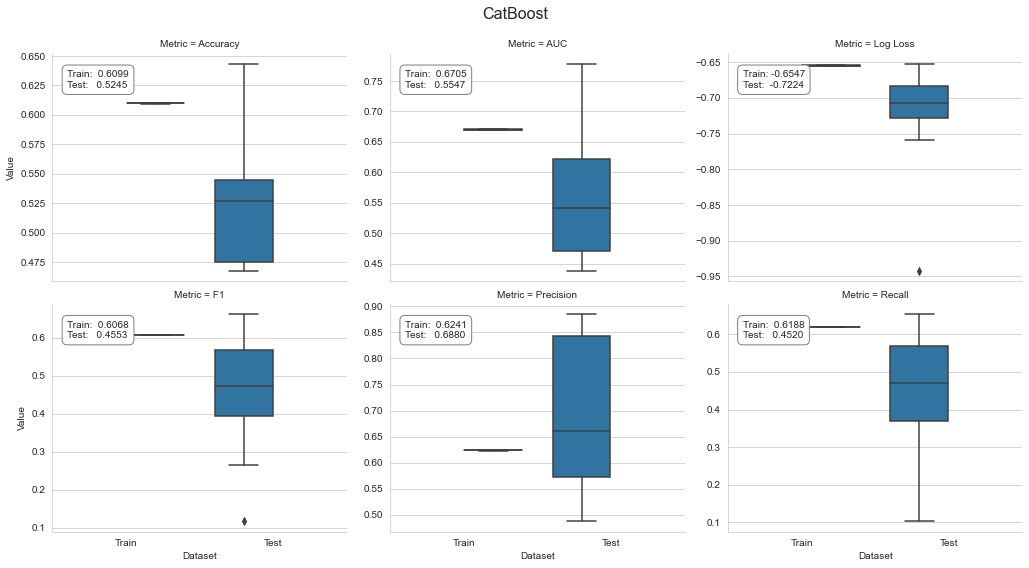

In [165]:
plot_result(cat_gpu_result, model='CatBoost')

## Compare Results

In [168]:
results = {'Baseline': dummy_result,
           'Random Forest': rf_result,
           'AdaBoost': ada_result,
           #'Gradient Booster': gb_result,
           'XGBoost': xbg_result,
           #'LightGBM Dummies': lgb_dummy_result,
           'LightGBM Factors': lgb_factor_result,
           'CatBoost': cat_result,
           'CatBoost GPU': cat_gpu_result}
df = pd.DataFrame()
for model, result in results.items():
    df = pd.concat([df, result.groupby(['Metric', 'Dataset']
                                       ).Value.mean().unstack()['Test'].to_frame(model)], axis=1)

df.T.sort_values('AUC', ascending=False)

Metric,AUC,Accuracy,F1,Log Loss,Precision,Recall
CatBoost GPU,0.554701,0.524483,0.455275,-0.722417,0.687972,0.452046
CatBoost,0.537947,0.511406,0.469847,-0.738676,0.676187,0.459557
LightGBM Factors,0.533223,0.518701,0.458861,-0.726202,0.676414,0.447183
XGBoost,0.531216,0.517643,0.475299,-0.706097,0.679752,0.469819
AdaBoost,0.527629,0.521072,0.493607,-0.693238,0.672037,0.473675
Random Forest,0.492892,0.503222,0.413541,-0.752993,0.659046,0.405265
Baseline,0.488587,0.488587,0.542459,-17.402794,0.653679,0.496144


In [171]:
algo_dict = dict(zip(['dummy_clf', 'random_forest', 'adaboost', 
                      'xgboost', 'lgb_factors', 'catboost', 'catboost_gpu'],
                     ['Baseline', 'Random Forest', 'AdaBoost', 
                      'XGBoost', 'LightGBM Factors', 'CatBoost', 'CatBoost GPU']))

In [172]:
print(run_time)

{'dummy_clf': 10.628664493560791, 'random_forest': 3924.6904633045197, 'adaboost': 2567.9258346557617, 'xgboost': 1543.3318808078766, 'lgb_factors': 142.74638533592224, 'catboost': 856.0707499980927, 'catboost_gpu': 781.0518379211426}


In [173]:
r = pd.Series(run_time).to_frame('t')
r.index = r.index.to_series().map(algo_dict)
r.to_csv(results_path / 'runtime.csv')

In [81]:
# r = pd.read_csv(results_path / 'runtime.csv', index_col=0)

In [174]:
auc = pd.concat([v.loc[(v.Dataset=='Test') & (v.Metric=='AUC'), 'Value'].to_frame('AUC').assign(Model=k) 
                 for k, v in results.items()])
# auc = auc[auc.Model != 'Baseline']

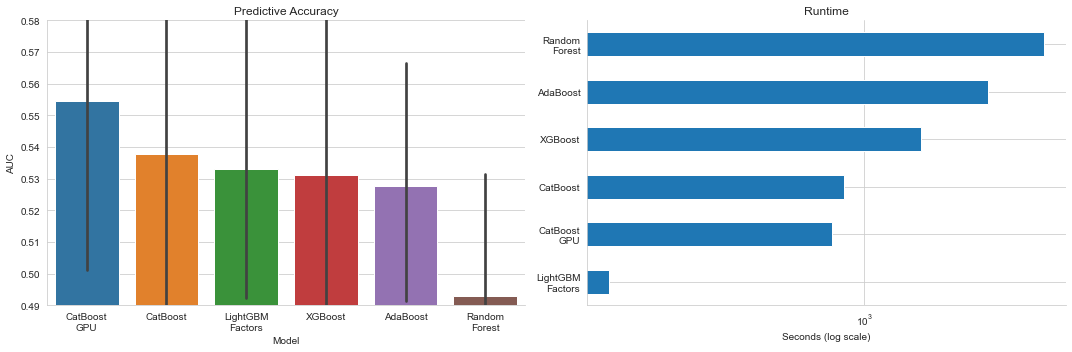

In [175]:
fig, axes = plt.subplots(figsize=(15, 5), ncols=2)
idx = df.T.drop('Baseline')['AUC'].sort_values(ascending=False).index
sns.barplot(x='Model', y='AUC',
            data=auc,
            order=idx, ax=axes[0])
axes[0].set_xticklabels([c.replace(' ', '\n') for c in idx])
axes[0].set_ylim(.49, .58)
axes[0].set_title('Predictive Accuracy')

(r.drop('Baseline').sort_values('t').rename(index=lambda x: x.replace(' ', '\n'))
 .plot.barh(title='Runtime', ax=axes[1], logx=True, legend=False))
axes[1].set_xlabel('Seconds (log scale)')
sns.despine()
fig.tight_layout()